In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import pylab as pl
%matplotlib inline
import scipy as sp
import scipy.sparse as sps
from sklearn.cluster import KMeans
from sklearn.cross_validation import KFold

In [2]:
def generateTwoGaussian():
    mean1 = [-2, -2]
    cov1 = [[1, 0], [0, 1]]  # diagonal covariance
    mean2 = [2,2]
    cov2 = [[1, 0], [0, 1]]  # diagonal covariance

    # data
    X = np.zeros((200,2))
    y = np.zeros(200,dtype=int)
    X[:100] = np.random.multivariate_normal(mean1, cov1, 100)
    X[100:] = np.random.multivariate_normal(mean2, cov2, 100)
    y[100:] = np.ones(100)
    return X,y,"Gaussian"

def generateXOR():
    mean1 = [-2, -2]
    cov1 = [[1, 0], [0, 1]]  # diagonal covariance
    mean2 = [2,2]
    cov2 = [[1, 0], [0, 1]]  # diagonal covariance

    # data
    X = np.zeros((400,2))
    y = np.zeros(400,dtype=int)
    X[:100] = np.random.multivariate_normal(mean1, cov1, 100)
    X[100:200] = np.random.multivariate_normal(mean2, cov2, 100)
    
    
    mean3 = [2, -2]
    cov3 = [[1, 0], [0, 1]]  # diagonal covariance
    mean4 = [-2, 2]
    cov4 = [[1, 0], [0, 1]]  # diagonal covariance

    X[200:300] = np.random.multivariate_normal(mean3, cov3, 100)
    X[300:] = np.random.multivariate_normal(mean4, cov4, 100)
    y[200:] = np.ones(200)
    
    return X,y,"XOR"

def generateTwoParabola():
    x1 = np.linspace(-10, 10, 40)
    y1 = .22*x1**2 + .024*x1 + .04  

    x2 = np.linspace(0, 20, 40)
    y2 = -.2*(x2-10)**2 - .024*(x2-10) + 35

    size = x1.shape[0]
    EACH = 10
    X = np.zeros((2*size*EACH,2))
    y = np.zeros(2*size*EACH,dtype=int)
    y[size*EACH:] = np.ones(size*EACH)

    cov = [[1, 0], [0, 1]]  # diagonal covariance
    for i in range(size):
        X[i*EACH:(i+1)*EACH] = np.random.multivariate_normal([x1[i],y1[i]], cov, EACH)
        X[(i+size)*EACH:(i+size+1)*EACH] = np.random.multivariate_normal([x2[i],y2[i]], cov, EACH)
    return X,y,"Parabolas"

In [100]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
def plotData(X,y,dataName):
    num = len(np.unique(sorted(y)))
    for i in range(num):
        plt.plot(X[:,0][y==i], X[:,1][y==i], colors[i%8]+'o')
    plt.axis('equal')
#     plt.savefig(dataName+'.jpg')
    plt.show()




def Prototyping(X,numP):
    kmeans = KMeans(init='k-means++',n_clusters=numP)
    kmeans.fit(X)

    centers = kmeans.cluster_centers_
    plotData(X,kmeans.labels_,"Two Gaussian")
    
    return centers
def distance2(p1,p2):
    ans = 0
    for i in xrange(p1.shape[0]):
        ans += (p1[i] - p2[i]) ** 2
    return ans
def similarity(p1,p2,sigma):
    return np.exp((-distance2(p1,p2))/(2*(sigma**2)))

In [27]:
def bipartiteUnsupervised(X,centers,sigma):
    numS = X.shape[0]
    numP = centers.shape[0]
    print numS,numP
    N = numS + numP
    W = sps.lil_matrix((N,N))
    for i in xrange(numS):
        for j in xrange(numP):
            W[i,numS+j] = similarity(X[i],centers[j],sigma)
            W[numS+j,i] = W[i,numS+j]
    W = sps.csr_matrix(W)
    d = np.array(W.sum(axis=0))
    D = sps.diags(d,[0])
    L = D - W
    return W,D,L

def bipartiteSupervised(X,y,centers,sigma):
    numS = X.shape[0]
    numP = centers.shape[0]
    numL = len(np.unique(sorted(y)))
    print numS,numP,numL
    N = numS+numP+numL
    W = sps.lil_matrix((N,N))
    for i in xrange(numS):
        for j in xrange(numP):
            W[i,numS+j] = similarity(X[i],centers[j],sigma)
            W[numS+j,i] = W[i,numS+j]

    P1 = np.sum(y)
    P2 = len(y) - P1
    for i in xrange(numS):
        W[i,numS+numP+y[i]] = 1.
        W[numS+numP+y[i],i] = 1.


    W = sps.csr_matrix(W)
    d = np.array(W.sum(axis=0))
    D = sps.diags(d,[0])
    L = D - W
    return W,D,L

def bipartite10Fold(X,y,centers,sigma):
    numS = X.shape[0]
    numP = centers.shape[0]
    numL = len(np.unique(sorted(y)))
    print numS,numP,numL
    N = numS+numP+numL
    W = sps.lil_matrix((N,N))
    for i in xrange(numS):
        for j in xrange(numP):
            W[i,numS+j] = similarity(X[i],centers[j],sigma)
            W[numS+j,i] = W[i,numS+j]

    kf = KFold(numS,n_folds=10,shuffle=True)
    for train_index,test_index in kf:
        break
    print "len train: ",len(train_index)
    P1 = np.sum(y)
    P2 = len(y) - P1
    for i in train_index:
        W[i,numS+numP+y[i]] = 1.
        W[numS+numP+y[i],i] = 1.


    W = sps.csr_matrix(W)
    d = np.array(W.sum(axis=0))
    D = sps.diags(d,[0])
    L = D - W
    return W,D,L

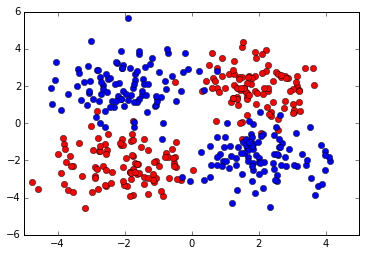

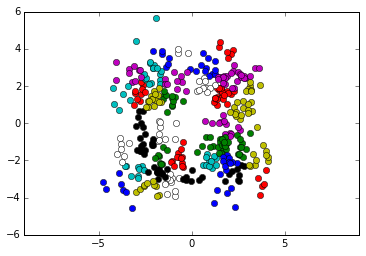

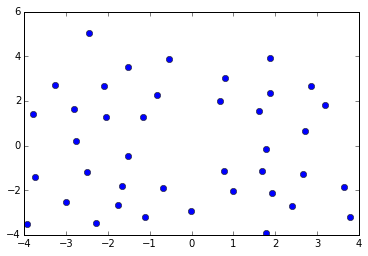

In [29]:
#supervisedBipartite10Fold
X,y,name = generateXOR()
plt.plot(X[:,0][y==0],X[:,1][y==0],'ro')
plt.plot(X[:,0][y==1],X[:,1][y==1],'bo')
plt.show()

numP = 40
centers = Prototyping(X,numP)
plt.plot(centers[:,0],centers[:,1],'bo')


400 40


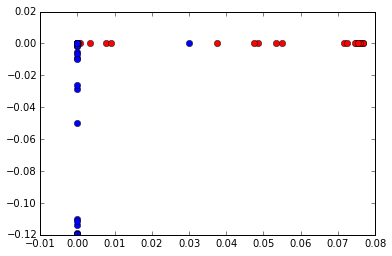

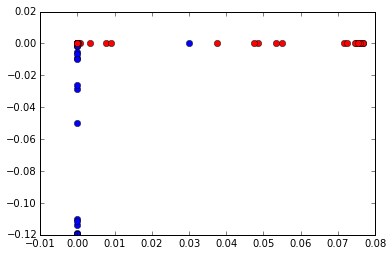

In [30]:
sigma = .1
numS = X.shape[0]

W,D,L = bipartiteUnsupervised(X,centers,sigma)
vals, vecs = sps.linalg.eigs(L, k=3)
vals = vals.real
vecs = vecs.real[:numS]
plt.plot(vecs[:,0][y==1],vecs[:,1][y==1],'ro')
plt.plot(vecs[:,0][y==0],vecs[:,1][y==0],'bo')
plt.show()
plt.plot(vecs[:,0][y==0],vecs[:,1][y==0],'bo')
plt.plot(vecs[:,0][y==1],vecs[:,1][y==1],'ro')
plt.show()

400 40 2


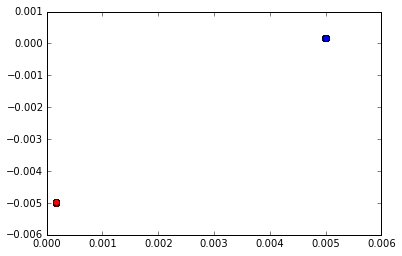

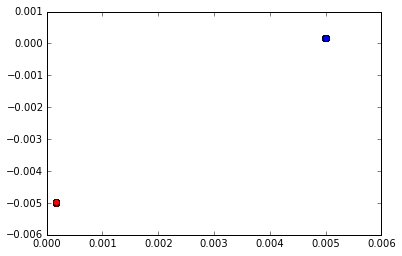

In [31]:
sigma = .1
numS = X.shape[0]

W,D,L = bipartiteSupervised(X,y,centers,sigma)
vals, vecs = sps.linalg.eigs(L, k=3)
vals = vals.real
vecs = vecs.real[:numS]
plt.plot(vecs[:,0][y==1],vecs[:,1][y==1],'ro')
plt.plot(vecs[:,0][y==0],vecs[:,1][y==0],'bo')
plt.show()
plt.plot(vecs[:,0][y==0],vecs[:,1][y==0],'bo')
plt.plot(vecs[:,0][y==1],vecs[:,1][y==1],'ro')
plt.show()

======================================================================= 1
400 40 2
len train:  360
------------------------------------------1 2---------------


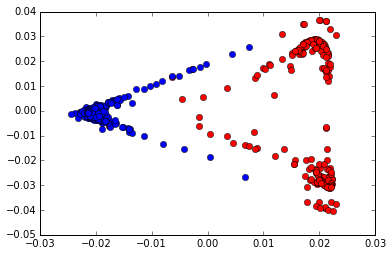

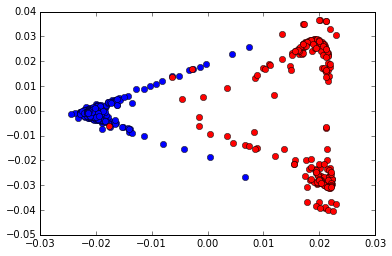

------------------------------------------3 4---------------


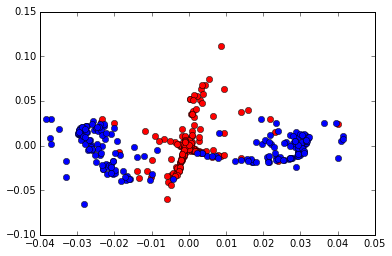

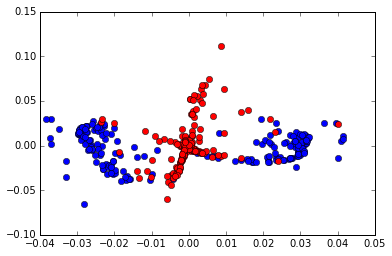

------------------------------------------5 6---------------


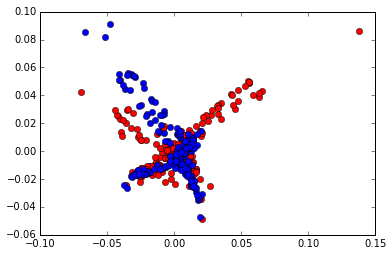

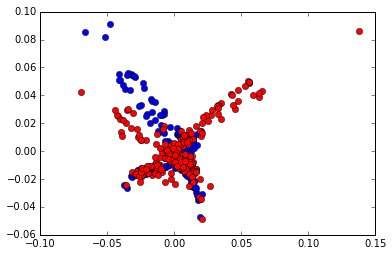

======================================================================= 2
400 40 2
len train:  360
------------------------------------------1 2---------------


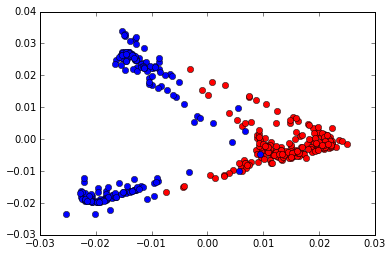

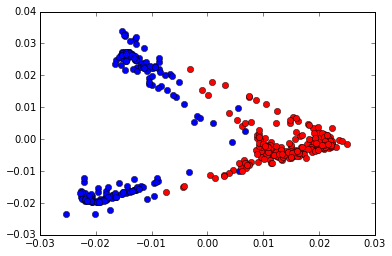

------------------------------------------3 4---------------


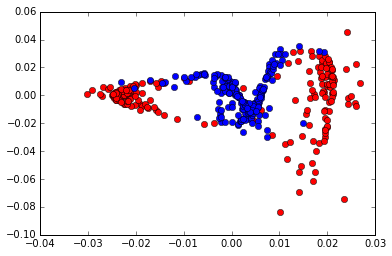

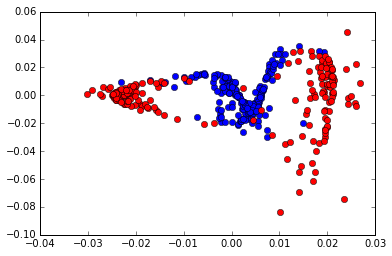

------------------------------------------5 6---------------


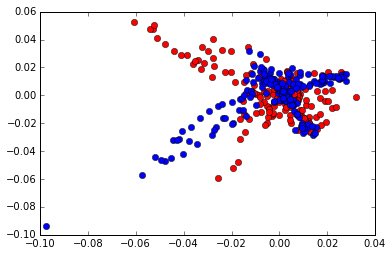

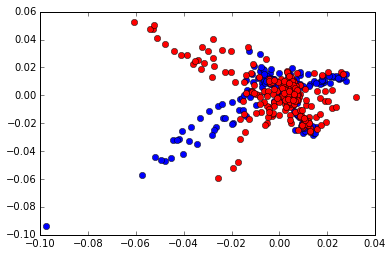

======================================================================= 3
400 40 2
len train:  360
------------------------------------------1 2---------------


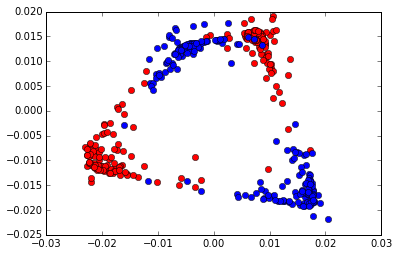

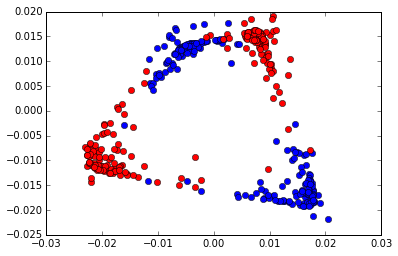

------------------------------------------3 4---------------


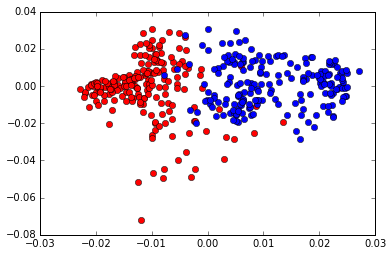

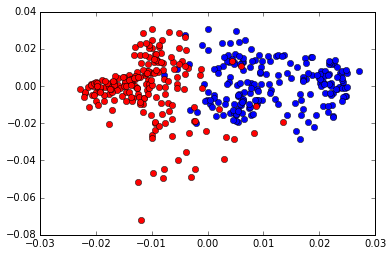

------------------------------------------5 6---------------


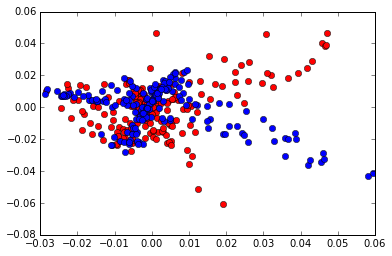

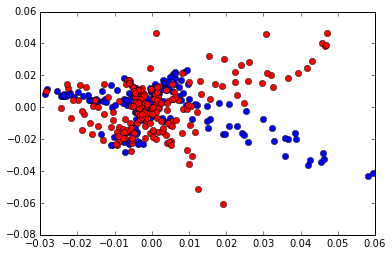

======================================================================= 4
400 40 2
len train:  360
------------------------------------------1 2---------------


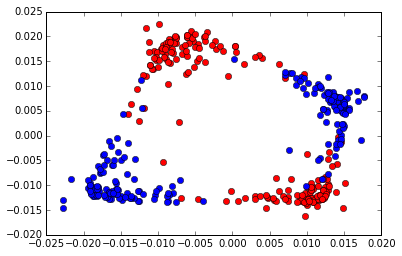

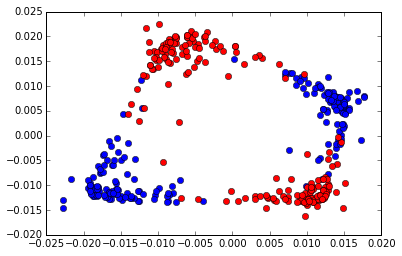

------------------------------------------3 4---------------


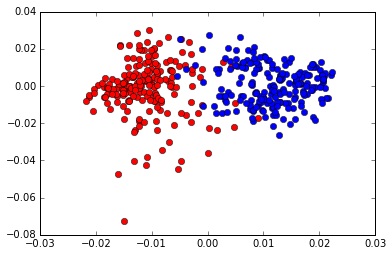

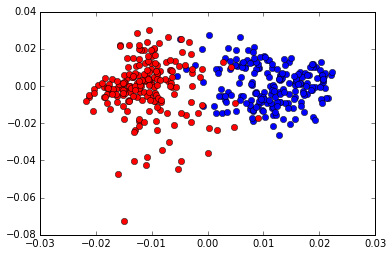

------------------------------------------5 6---------------


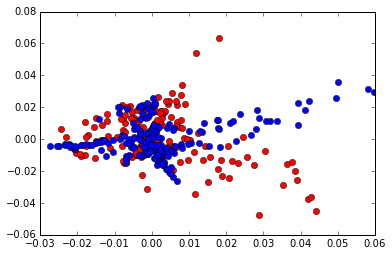

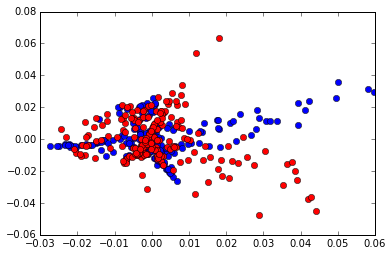

======================================================================= 5
400 40 2
len train:  360
------------------------------------------1 2---------------


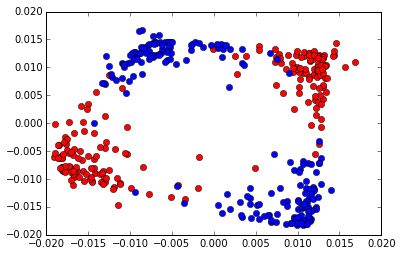

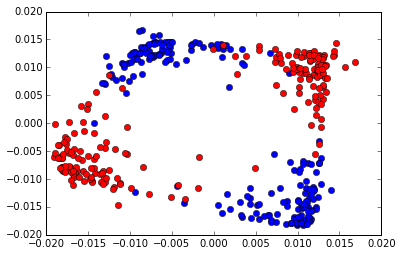

------------------------------------------3 4---------------


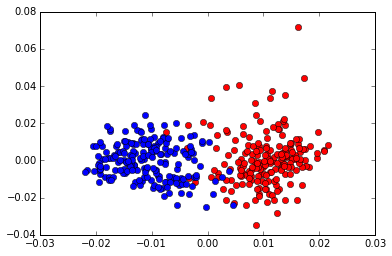

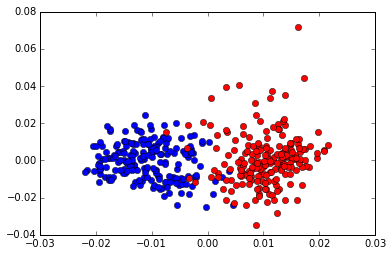

------------------------------------------5 6---------------


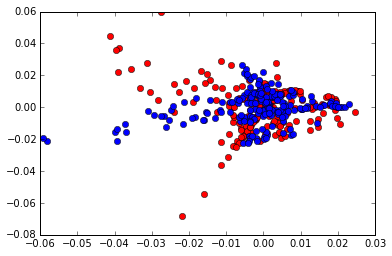

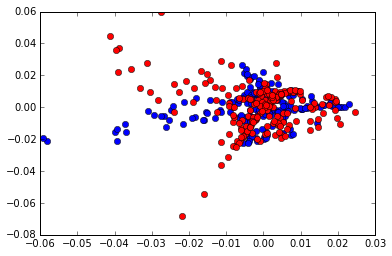

======================================================================= 6
400 40 2
len train:  360
------------------------------------------1 2---------------


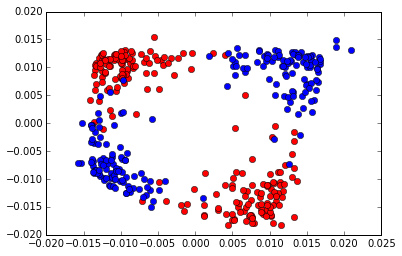

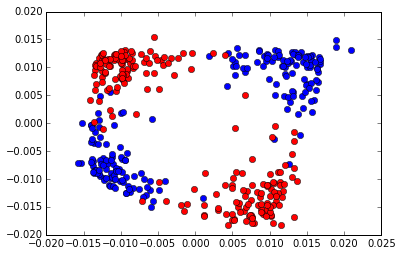

------------------------------------------3 4---------------


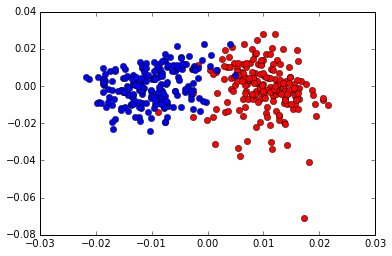

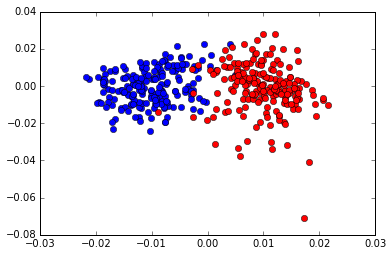

------------------------------------------5 6---------------


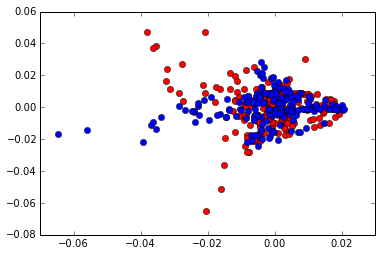

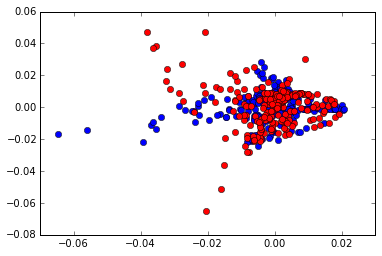

======================================================================= 7
400 40 2
len train:  360
------------------------------------------1 2---------------


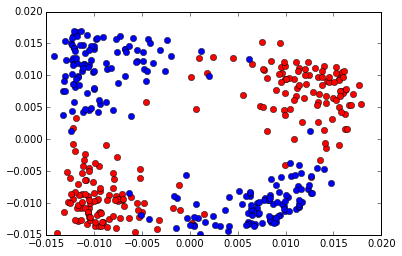

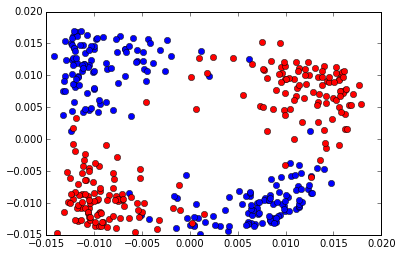

------------------------------------------3 4---------------


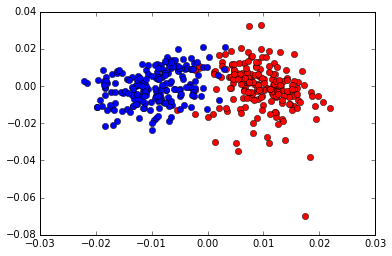

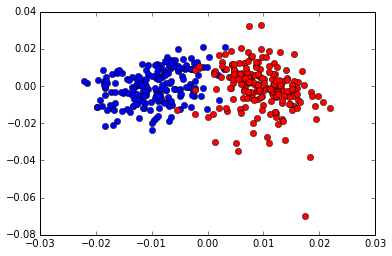

------------------------------------------5 6---------------


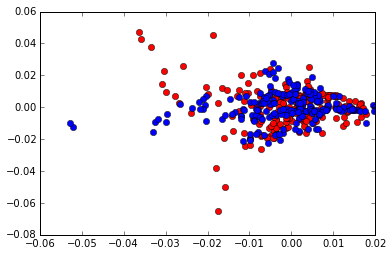

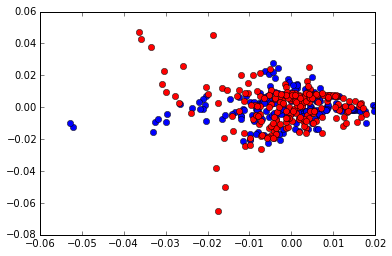

======================================================================= 8
400 40 2
len train:  360
------------------------------------------1 2---------------


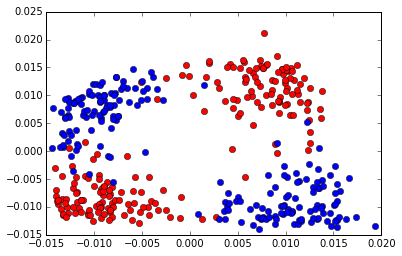

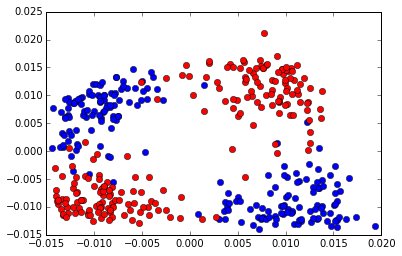

------------------------------------------3 4---------------


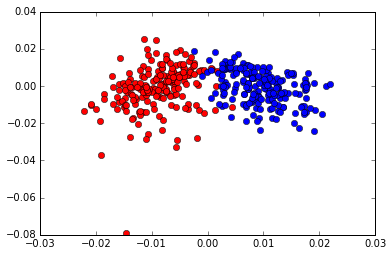

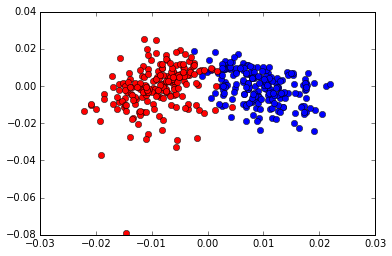

------------------------------------------5 6---------------


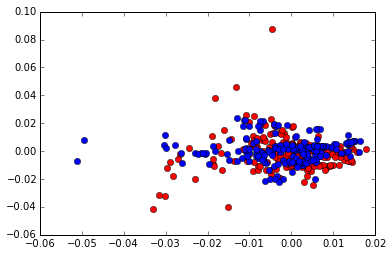

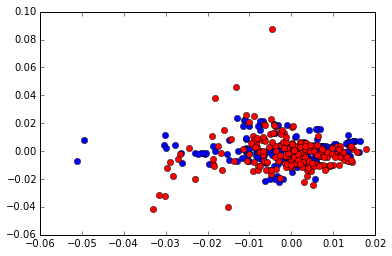

======================================================================= 9
400 40 2
len train:  360
------------------------------------------1 2---------------


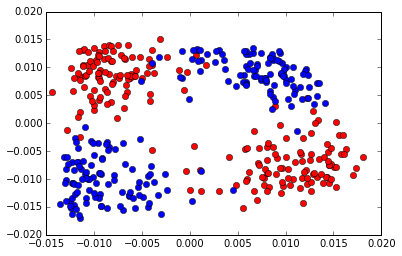

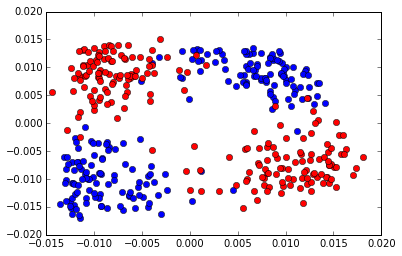

------------------------------------------3 4---------------


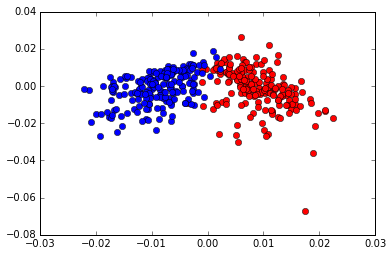

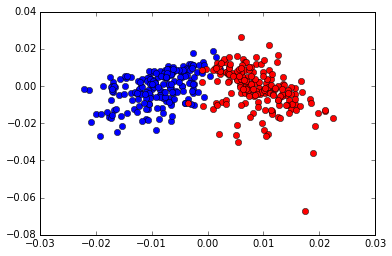

------------------------------------------5 6---------------


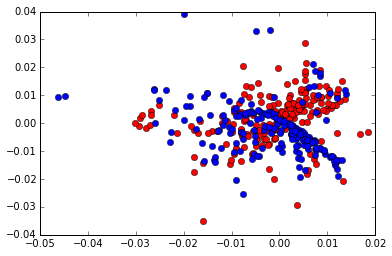

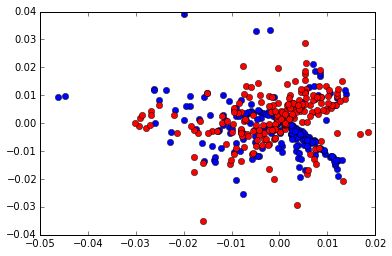

======================================================================= 10
400 40 2
len train:  360
------------------------------------------1 2---------------


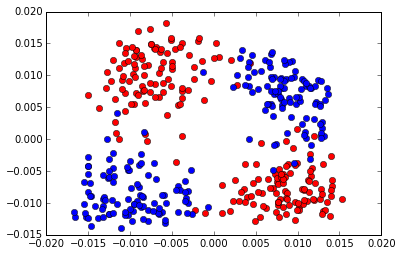

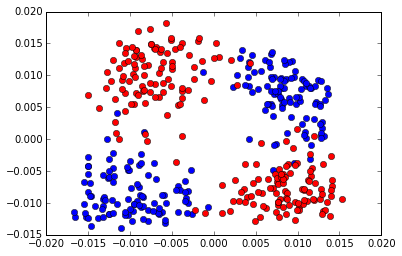

------------------------------------------3 4---------------


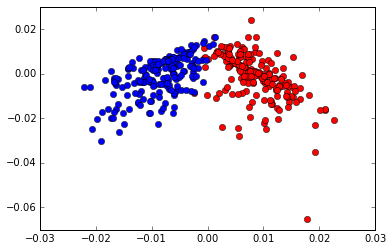

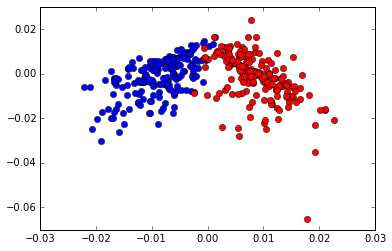

------------------------------------------5 6---------------


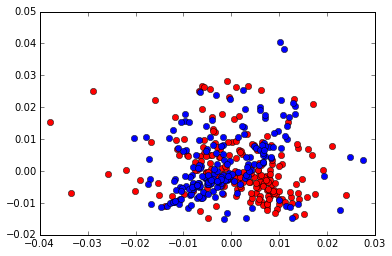

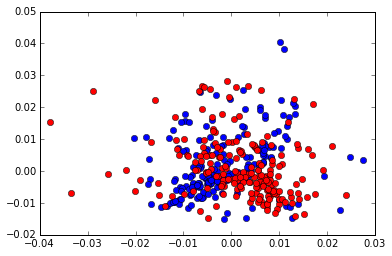

======================================================================= 11
400 40 2
len train:  360
------------------------------------------1 2---------------


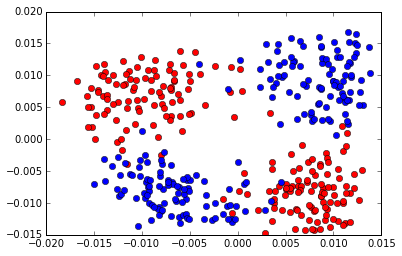

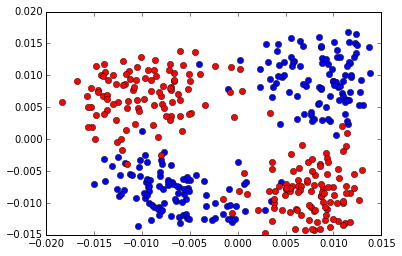

------------------------------------------3 4---------------


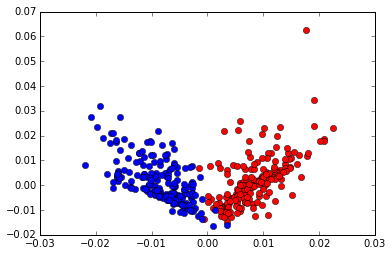

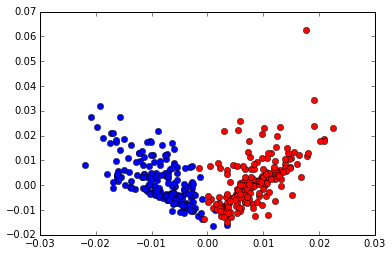

------------------------------------------5 6---------------


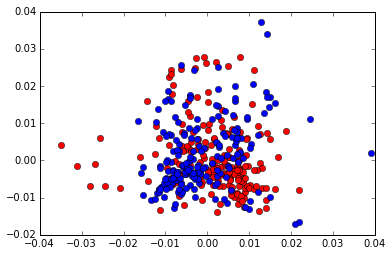

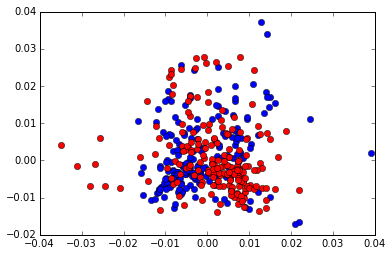

======================================================================= 12
400 40 2
len train:  360
------------------------------------------1 2---------------


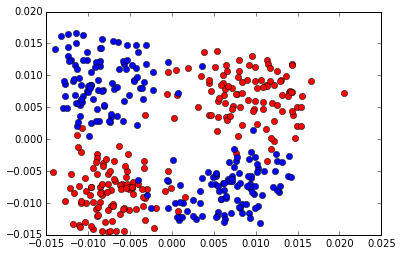

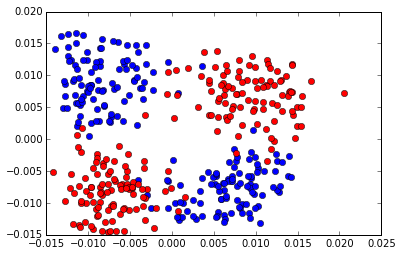

------------------------------------------3 4---------------


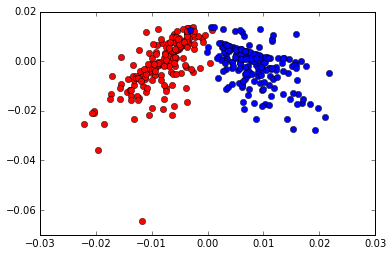

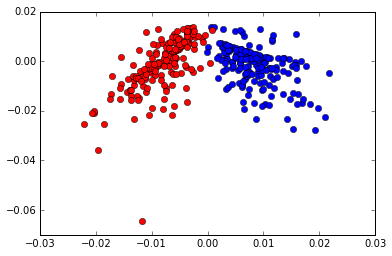

------------------------------------------5 6---------------


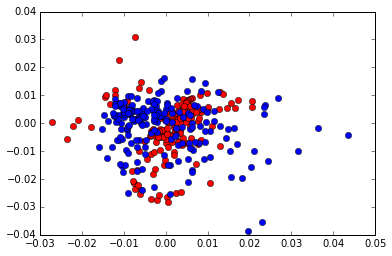

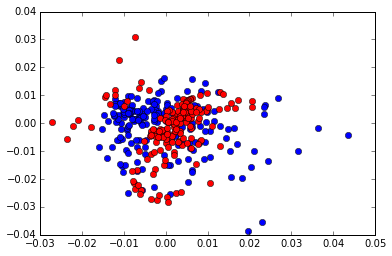

======================================================================= 13
400 40 2
len train:  360
------------------------------------------1 2---------------


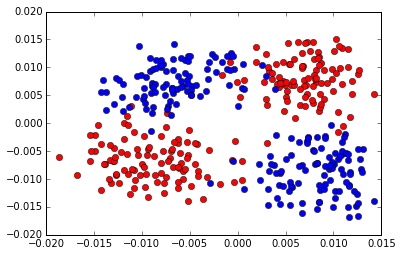

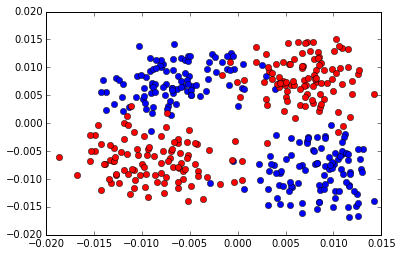

------------------------------------------3 4---------------


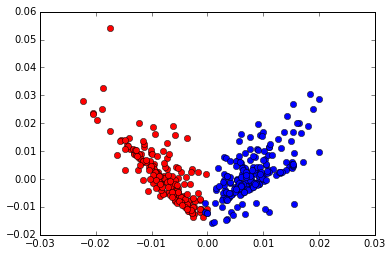

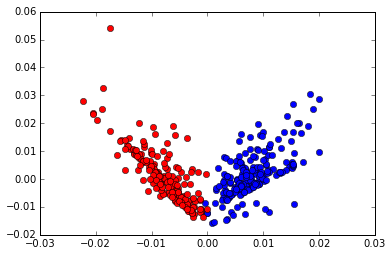

------------------------------------------5 6---------------


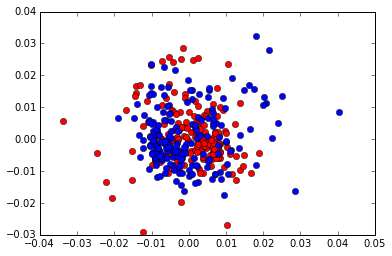

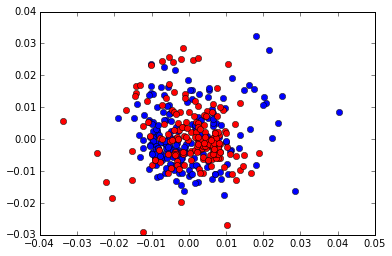

======================================================================= 14
400 40 2
len train:  360
------------------------------------------1 2---------------


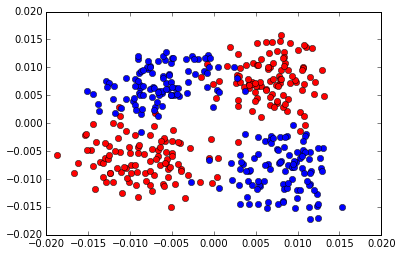

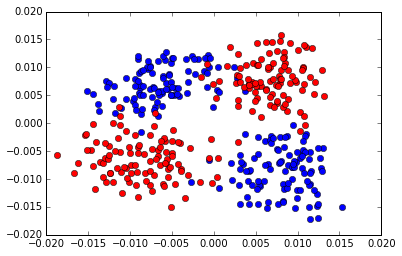

------------------------------------------3 4---------------


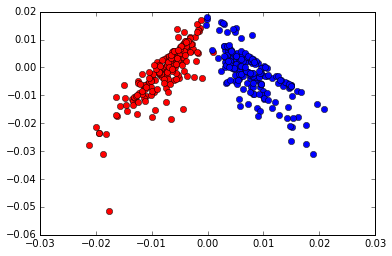

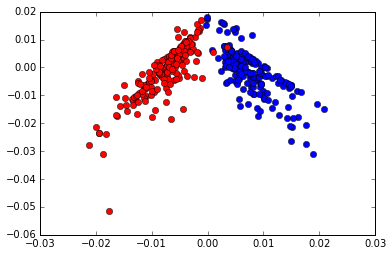

------------------------------------------5 6---------------


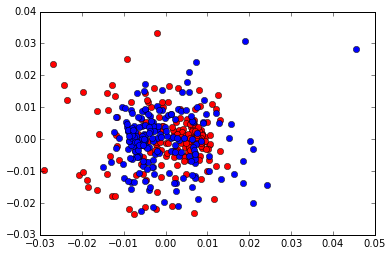

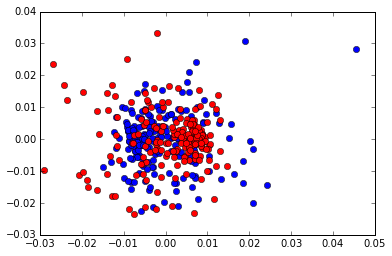

======================================================================= 15
400 40 2
len train:  360
------------------------------------------1 2---------------


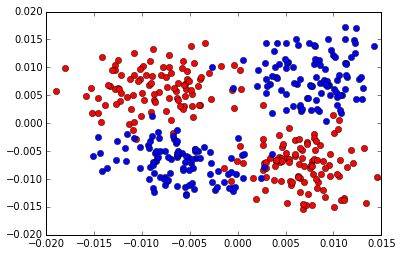

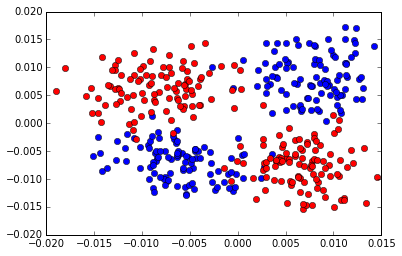

------------------------------------------3 4---------------


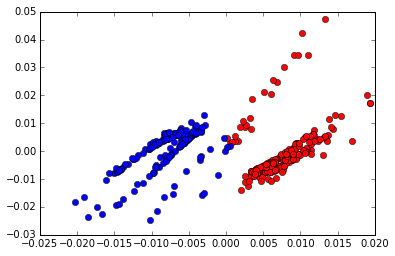

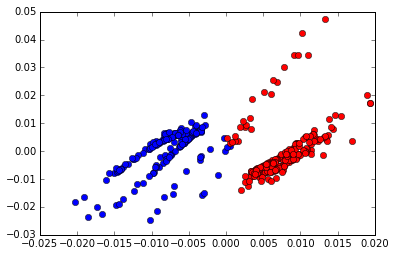

------------------------------------------5 6---------------


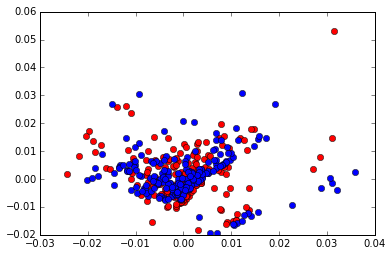

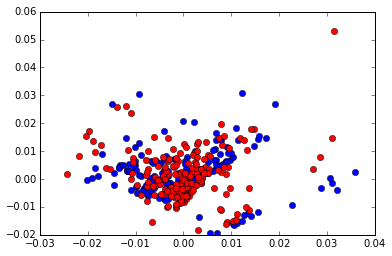

======================================================================= 16
400 40 2
len train:  360
------------------------------------------1 2---------------


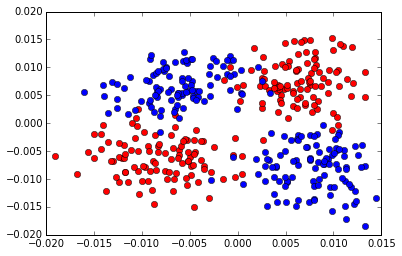

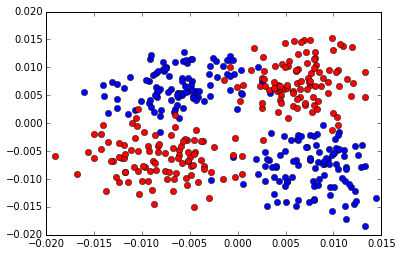

------------------------------------------3 4---------------


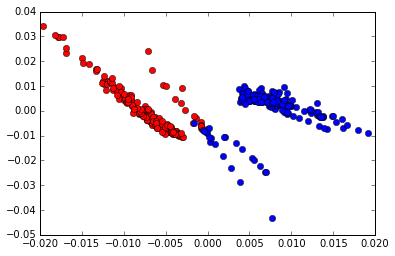

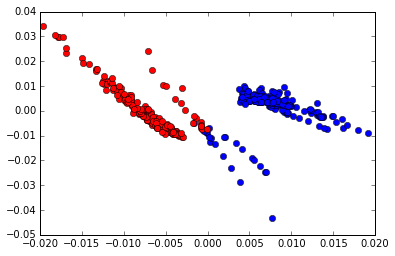

------------------------------------------5 6---------------


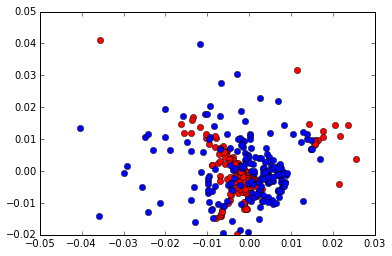

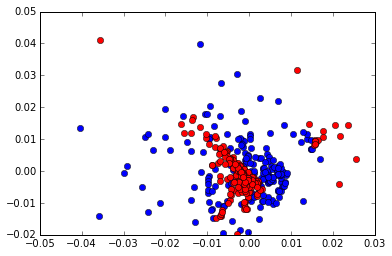

======================================================================= 17
400 40 2
len train:  360
------------------------------------------1 2---------------


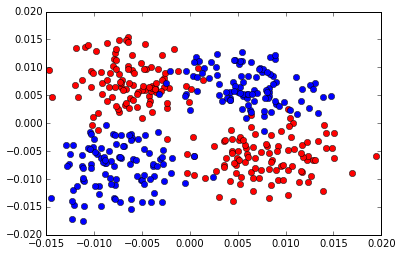

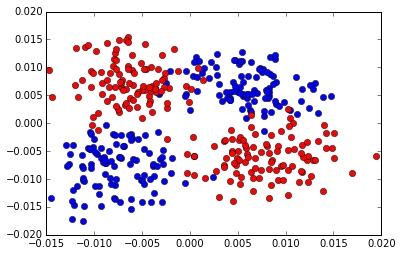

------------------------------------------3 4---------------


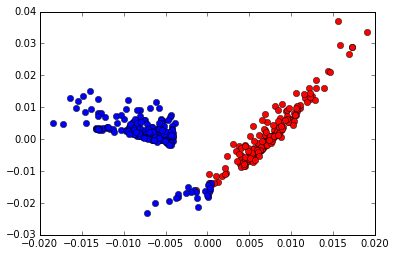

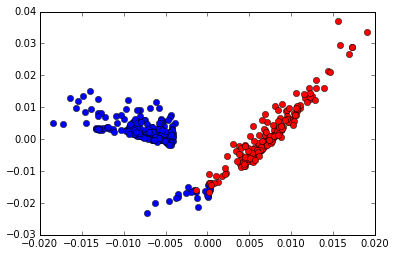

------------------------------------------5 6---------------


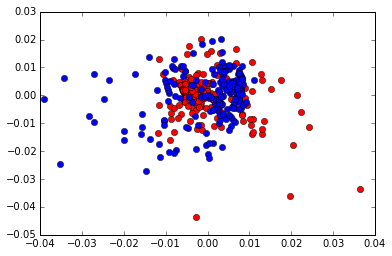

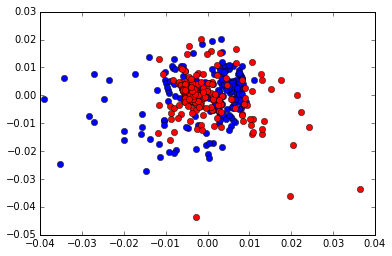

======================================================================= 18
400 40 2
len train:  360
------------------------------------------1 2---------------


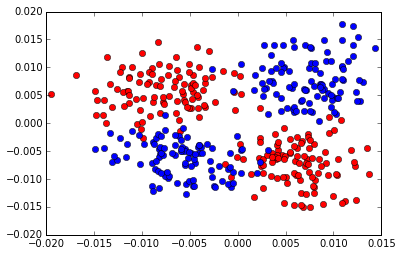

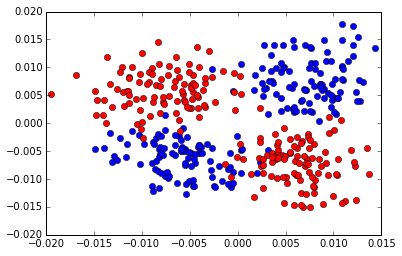

------------------------------------------3 4---------------


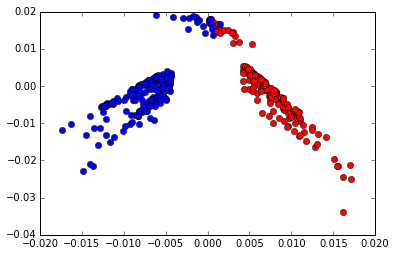

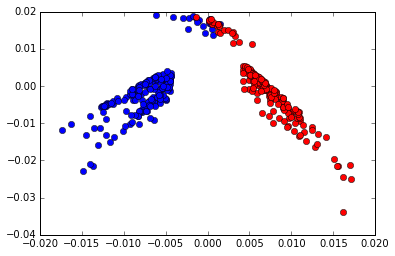

------------------------------------------5 6---------------


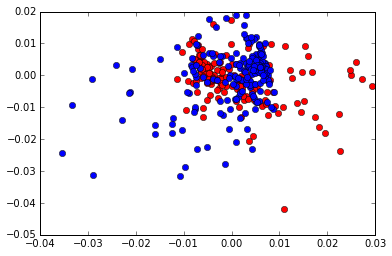

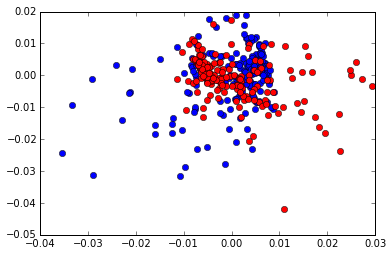

======================================================================= 19
400 40 2
len train:  360
------------------------------------------1 2---------------


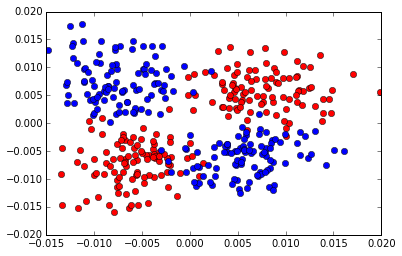

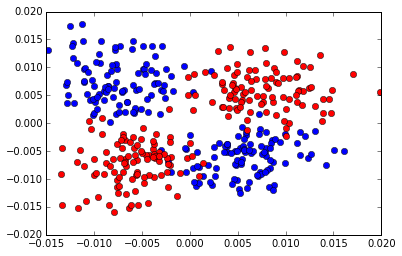

------------------------------------------3 4---------------


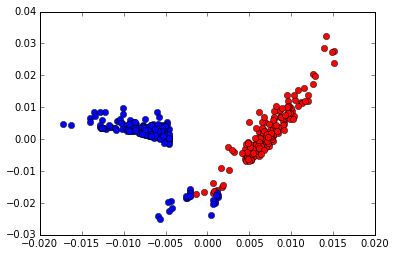

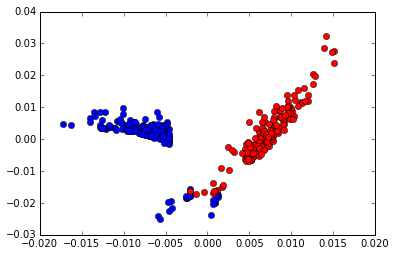

------------------------------------------5 6---------------


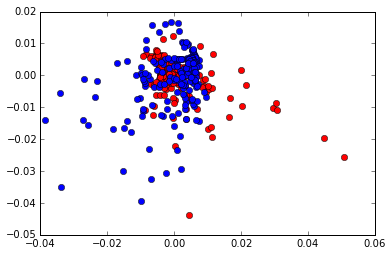

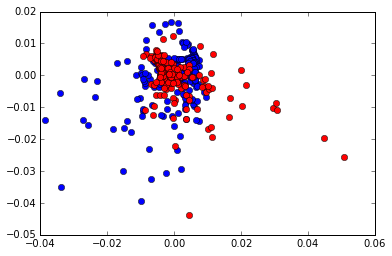

In [49]:

sigma = 20

for sigma in xrange(1,20):
    print '=======================================================================',sigma
    W,D,L = bipartite10Fold(X,y,centers,sigma)
    vals, vecs = sps.linalg.eigs(L, M=D, k=7)
    vals = vals.real
    vecs = vecs.real[:numS]
    for i in xrange(1,7,2):
        print '------------------------------------------'+str(i),str(i+1)+'---------------'
        plt.plot(vecs[:,i][y==1],vecs[:,i+1][y==1],'ro')
        plt.plot(vecs[:,i][y==0],vecs[:,i+1][y==0],'bo')
        plt.show()
        plt.plot(vecs[:,i][y==0],vecs[:,i+1][y==0],'bo')
        plt.plot(vecs[:,i][y==1],vecs[:,i+1][y==1],'ro')
        plt.show()


400 40 2
len train:  360
------------------------------------------1 2---------------


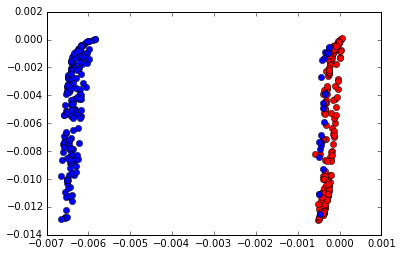

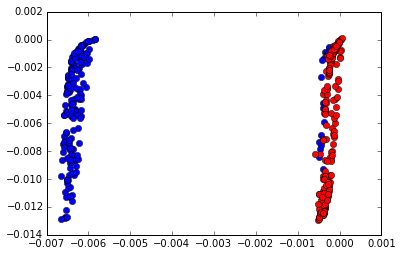

------------------------------------------3 4---------------


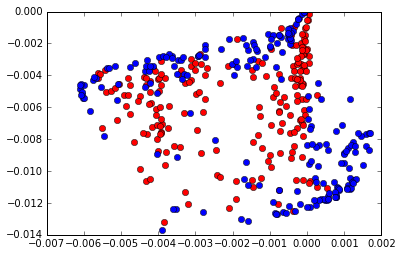

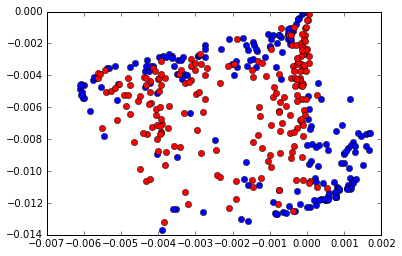

------------------------------------------5 6---------------


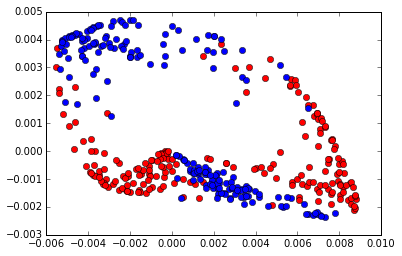

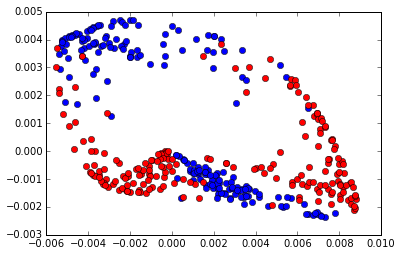

In [43]:
sigma = 6


W,D,L = bipartite10Fold(X,y,centers,sigma)
vals, vecs = sps.linalg.eigs(L, k=7)
vals = vals.real
vecs = vecs.real[:numS]
for i in xrange(1,7,2):
    print '------------------------------------------'+str(i),str(i+1)+'---------------'
    plt.plot(vecs[:,i][y==1],vecs[:,i+1][y==1],'ro')
    plt.plot(vecs[:,i][y==0],vecs[:,i+1][y==0],'bo')
    plt.show()
    plt.plot(vecs[:,i][y==0],vecs[:,i+1][y==0],'bo')
    plt.plot(vecs[:,i][y==1],vecs[:,i+1][y==1],'ro')
    plt.show()

400 40 2
len train:  360
------------------------------------------1 2---------------


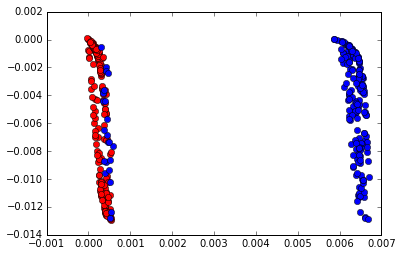

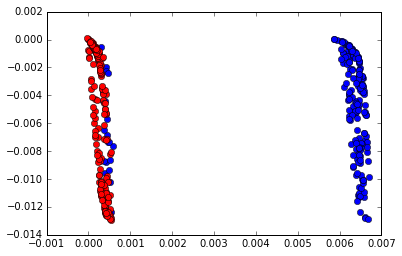

------------------------------------------3 4---------------


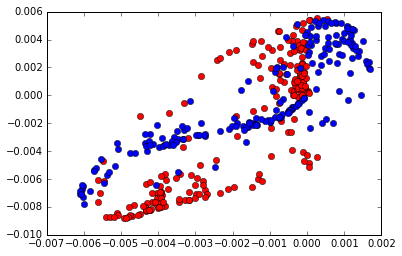

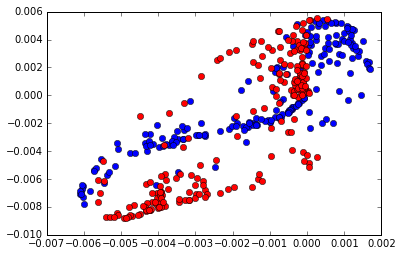

------------------------------------------5 6---------------


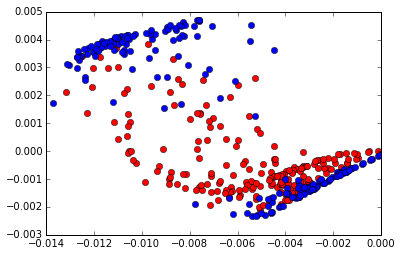

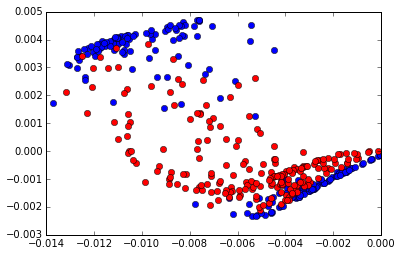

In [45]:
sigma = 6


W,D,L = bipartite10Fold(X,y,centers,sigma)
d = np.array(W.sum(axis=0))
d12 = d**(-.5)
D12 = sps.diags(d,[0])
Ln = D12.dot(L.dot(D12))
vals, vecs = sps.linalg.eigs(L, k=7)
vals = vals.real
vecs = vecs.real[:numS]
for i in xrange(1,7,2):
    print '------------------------------------------'+str(i),str(i+1)+'---------------'
    plt.plot(vecs[:,i][y==1],vecs[:,i+1][y==1],'ro')
    plt.plot(vecs[:,i][y==0],vecs[:,i+1][y==0],'bo')
    plt.show()
    plt.plot(vecs[:,i][y==0],vecs[:,i+1][y==0],'bo')
    plt.plot(vecs[:,i][y==1],vecs[:,i+1][y==1],'ro')
    plt.show()

In [72]:
from sklearn import neighbors
kf = KFold(numS,n_folds=10,shuffle=True)

Means = np.zeros(20)
for sigma in xrange(1,20):
    acc = []
    for train_index,test_index in kf:
        W,D,L = bipartite10Fold2(X,y,centers,sigma,train_index,test_index)
        vals, vecs = sps.linalg.eigs(L, M=D, k=7)
        vals = vals.real
        vecs = vecs.real[:numS]
        yTrain = y[train_index]
        yTest = y[test_index]
        newRepTrain = vecs[:,:6][train_index]
        newRepTest = vecs[:,:6][test_index]
        NN = neighbors.KNeighborsClassifier()
        NN.fit(newRepTrain,yTrain)
        XPred = NN.predict(newRepTest)
        acc.append(np.sum(XPred==yTest)*1.0/yTest.shape[0])
    print "sigma is:",sigma," ,accuracy:",acc
    print "Mean:", np.mean(acc), "std:",np.std(acc)
    Means[sigma-1] = np.mean(acc)

sigma is: 1  ,accuracy: [0.875, 0.92500000000000004, 0.92500000000000004, 0.94999999999999996, 0.90000000000000002, 0.97499999999999998, 0.94999999999999996, 0.94999999999999996, 0.94999999999999996, 0.94999999999999996]
Mean: 0.935 std: 0.0278388218142
sigma is: 2  ,accuracy: [0.92500000000000004, 0.92500000000000004, 0.92500000000000004, 0.94999999999999996, 0.92500000000000004, 0.97499999999999998, 0.92500000000000004, 0.97499999999999998, 0.94999999999999996, 0.94999999999999996]
Mean: 0.9425 std: 0.0195256241898
sigma is: 3  ,accuracy: [0.90000000000000002, 0.92500000000000004, 0.90000000000000002, 0.94999999999999996, 0.94999999999999996, 0.97499999999999998, 0.92500000000000004, 0.97499999999999998, 0.94999999999999996, 0.94999999999999996]
Mean: 0.94 std: 0.025495097568
sigma is: 4  ,accuracy: [0.90000000000000002, 0.92500000000000004, 0.92500000000000004, 0.94999999999999996, 0.94999999999999996, 1.0, 0.92500000000000004, 0.97499999999999998, 0.94999999999999996, 0.94999999999

(20L,)


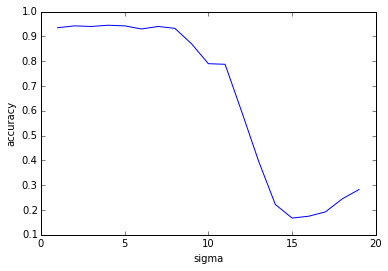

In [76]:
print Means.shape
plt.plot(range(1,20),Means[:19])
plt.xlabel('sigma')
plt.ylabel('accuracy')

In [210]:
def bipartite10Fold2(X,y,centers,sigma,train_index,test_index):
    numS = X.shape[0]
    numP = centers.shape[0]
    numL = len(np.unique(sorted(y)))
    print numS,numP,numL
    N = numS+numP+numL
    W = sps.lil_matrix((N,N))
    for i in xrange(numS):
        for j in xrange(numP):
            W[i,numS+j] = similarity(X[i],centers[j],sigma)
            W[numS+j,i] = W[i,numS+j]
#     print "len train: ",len(train_index)
    P1 = np.sum(y)
    P2 = len(y) - P1
    for i in train_index:
        W[i,numS+numP+y[i]] = 1.
        W[numS+numP+y[i],i] = 1.


    W = sps.csr_matrix(W)
    d = np.array(W.sum(axis=0))
    D = sps.diags(d,[0])
    L = D - W
    return W,D,L

def supervised10FoldRepresentation(X,y,sigma):
    numP = 40
    centers = Prototyping(X,numP)
    numS = X.shape[0]
    kf = KFold(numS,n_folds=10,shuffle=True)
    fi = 0
    for train_index,test_index in kf:
        print "fold number:",fi
        fi += 1
        W,D,L = bipartite10Fold2(X,y,centers,sigma,train_index,test_index)
        vals, vecs = sps.linalg.eigs(L, M=D, k=7)
        vals = vals.real
        vecs = vecs.real[:numS]
        yTr = y[train_index]
        yTe = y[test_index]
        for i in xrange(1,7,2):
            print '------------------------------------------'+str(i),str(i+1)+'---------------'
            plt.plot(vecs[:,i][train_index][yTr==1],vecs[:,i+1][train_index][yTr==1],'ro')
            plt.plot(vecs[:,i][train_index][yTr==0],vecs[:,i+1][train_index][yTr==0],'bo')
            plt.show()
            plt.plot(vecs[:,i][train_index][yTr==0],vecs[:,i+1][train_index][yTr==0],'bo')
            plt.plot(vecs[:,i][train_index][yTr==1],vecs[:,i+1][train_index][yTr==1],'ro')
            plt.show()
            plt.plot(vecs[:,i][test_index][yTe==1],vecs[:,i+1][test_index][yTe==1],'rx')
            plt.plot(vecs[:,i][test_index][yTe==0],vecs[:,i+1][test_index][yTe==0],'bx')
            plt.show()
            plt.plot(vecs[:,i][test_index][yTe==0],vecs[:,i+1][test_index][yTe==0],'bx')
            plt.plot(vecs[:,i][test_index][yTe==1],vecs[:,i+1][test_index][yTe==1],'rx')
            plt.show()
def supervised10Fold(X,y,numP,sigma):
#     numP = 40
    numS = X.shape[0]
    centers = Prototyping(X,numP)
    acc = []
    kf = KFold(numS,n_folds=10,shuffle=True)
    i = 0
    for train_index,test_index in kf:
        W,D,L = bipartite10Fold2(X,y,centers,sigma,train_index,test_index)
        vals, vecs = sps.linalg.eigs(L, M=D, k=7)
        vals = vals.real
        vecs = vecs.real[:numS]
        yTrain = y[train_index]
        yTest = y[test_index]
        newRepTrain = vecs[:,1:7][train_index]
        newRepTest = vecs[:,1:7][test_index]
        NN = neighbors.KNeighborsClassifier(n_neighbors=2)
        NN.fit(newRepTrain,yTrain)
        XPred = NN.predict(newRepTest)
        acc.append(np.sum(XPred==yTest)*1.0/yTest.shape[0])
        print i,":",acc[i]
        i += 1
    return np.mean(acc)   

<h1 style="color:purple">Proposed 10 Fold</h1>

-----------------------------------------------------numP: 10


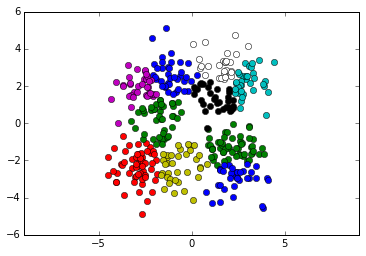

400 10 2
0 : 0.925
400 10 2
1 : 0.9
400 10 2
2 : 0.95
400 10 2
3 : 0.975
400 10 2
4 : 0.925
400 10 2
5 : 0.95
400 10 2
6 : 0.9
400 10 2
7 : 0.9
400 10 2
8 : 0.875
400 10 2
9 : 0.925
accuracy: 0.9225
-----------------------------------------------------numP: 20


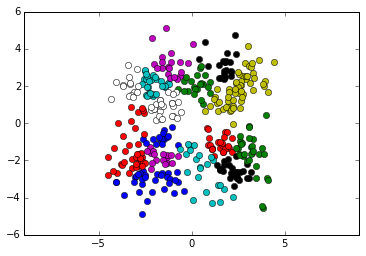

400 20 2
0 : 0.9
400 20 2
1 : 0.975
400 20 2
2 : 0.875
400 20 2
3 : 0.975
400 20 2
4 : 0.925
400 20 2
5 : 0.975
400 20 2
6 : 0.95
400 20 2
7 : 0.975
400 20 2
8 : 0.95
400 20 2
9 : 0.9
accuracy: 0.94
-----------------------------------------------------numP: 30


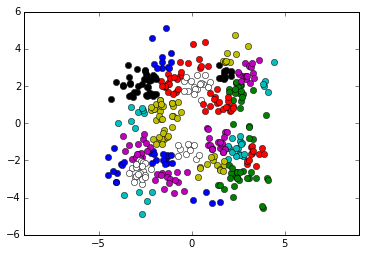

400 30 2
0 : 0.925
400 30 2
1 : 0.9
400 30 2
2 : 0.9
400 30 2
3 : 0.9
400 30 2
4 : 0.925
400 30 2
5 : 0.95
400 30 2
6 : 0.975
400 30 2
7 : 0.925
400 30 2
8 : 1.0
400 30 2
9 : 0.9
accuracy: 0.93
-----------------------------------------------------numP: 40


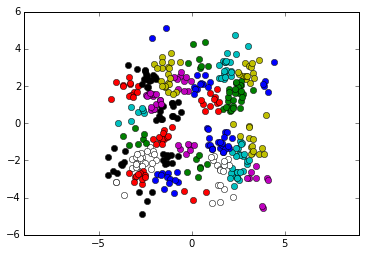

400 40 2
0 : 0.9
400 40 2
1 : 0.975
400 40 2
2 : 0.95
400 40 2
3 : 0.875
400 40 2
4 : 0.95
400 40 2
5 : 0.95
400 40 2
6 : 0.9
400 40 2
7 : 0.975
400 40 2
8 : 0.9
400 40 2
9 : 0.925
accuracy: 0.93


In [124]:
X,y,name = generateXOR()
for numP in xrange(10,41,10):
    print '-----------------------------------------------------numP:',numP
    t = supervised10Fold(X,y,numP,1)
    print "accuracy:",t
# supervised10FoldRepresentation(X,y,sigma)

In [202]:
def runP(X,Y):
    Means = np.zeros(20)
    for numP in xrange(20,61,5):
        print wineX.shape
        Means[numP/5-4] = supervised10Fold(X,Y,numP,2)
        # supervised10FoldRepresentation(wineX,wineY,1)
    return Means

def runSigma(X,Y):
    Means = np.zeros(14)
    numP = 30
    idx = 0
    for sigma in sigmas:
        print '--------------------------------------- sigma: ',sigma
        Means[idx] = supervised10Fold(X,Y,numP,sigma)
#         try:
#             Means[idx] = supervised10Fold(X,Y,numP,sigma)
#         except Exception as e:
#             print e
        idx += 1
        # supervised10FoldRepresentation(wineX,wineY,1)
    return Means

--------------------------------------- sigma:  10


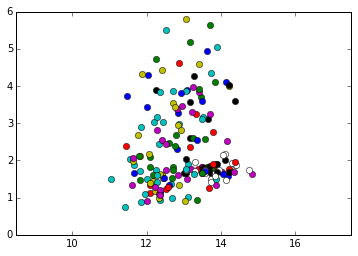

178 30 3
0 : 0.555555555556
178 30 3
1 : 0.611111111111
178 30 3
2 : 0.444444444444
178 30 3
3 : 0.5
178 30 3
4 : 0.611111111111
178 30 3
5 : 0.833333333333
178 30 3
6 : 0.555555555556
178 30 3
7 : 0.666666666667
178 30 3
8 : 0.823529411765
178 30 3
9 : 0.705882352941
--------------------------------------- sigma:  15


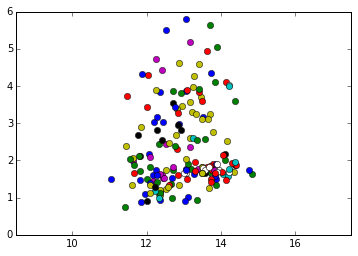

178 30 3
0 : 0.666666666667
178 30 3
1 : 0.666666666667
178 30 3
2 : 0.666666666667
178 30 3
3 : 0.777777777778
178 30 3
4 : 0.555555555556
178 30 3
5 : 0.666666666667
178 30 3
6 : 0.722222222222
178 30 3
7 : 0.666666666667
178 30 3
8 : 0.705882352941
178 30 3
9 : 0.588235294118
--------------------------------------- sigma:  20


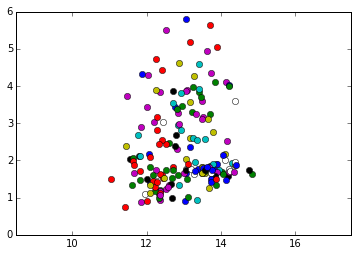

178 30 3
0 : 0.888888888889
178 30 3
1 : 0.777777777778
178 30 3
2 : 0.555555555556
178 30 3
3 : 0.555555555556
178 30 3
4 : 0.722222222222
178 30 3
5 : 0.722222222222
178 30 3
6 : 0.611111111111
178 30 3
7 : 0.888888888889
178 30 3
8 : 0.823529411765
178 30 3
9 : 0.588235294118
--------------------------------------- sigma:  25


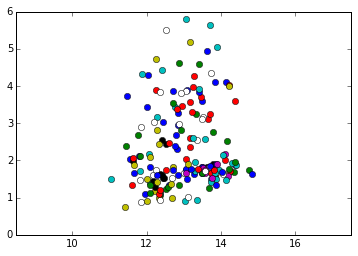

178 30 3
0 : 0.666666666667
178 30 3
1 : 0.666666666667
178 30 3
2 : 0.722222222222
178 30 3
3 : 0.666666666667
178 30 3
4 : 0.833333333333
178 30 3
5 : 0.777777777778
178 30 3
6 : 0.666666666667
178 30 3
7 : 0.611111111111
178 30 3
8 : 0.764705882353
178 30 3
9 : 0.588235294118
--------------------------------------- sigma:  30


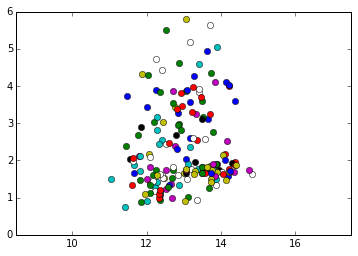

178 30 3
0 : 0.555555555556
178 30 3
1 : 0.611111111111
178 30 3
2 : 0.722222222222
178 30 3
3 : 0.888888888889
178 30 3
4 : 0.777777777778
178 30 3
5 : 0.611111111111
178 30 3
6 : 0.833333333333
178 30 3
7 : 0.777777777778
178 30 3
8 : 0.529411764706
178 30 3
9 : 0.588235294118
--------------------------------------- sigma:  35


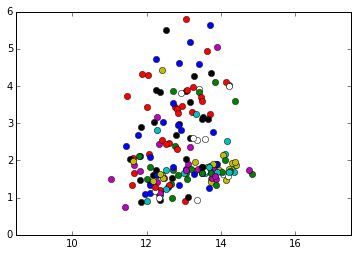

178 30 3
0 : 0.555555555556
178 30 3
1 : 0.611111111111
178 30 3
2 : 0.722222222222
178 30 3
3 : 0.777777777778
178 30 3
4 : 0.666666666667
178 30 3
5 : 0.722222222222
178 30 3
6 : 0.722222222222
178 30 3
7 : 0.722222222222
178 30 3
8 : 0.705882352941
178 30 3
9 : 0.647058823529
--------------------------------------- sigma:  40


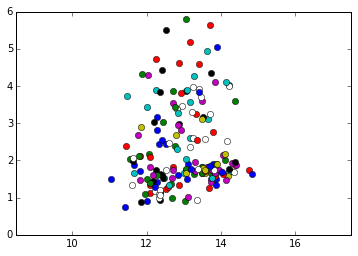

178 30 3
0 : 0.833333333333
178 30 3
1 : 0.777777777778
178 30 3
2 : 0.5
178 30 3
3 : 0.555555555556
178 30 3
4 : 0.722222222222
178 30 3
5 : 0.666666666667
178 30 3
6 : 0.722222222222
178 30 3
7 : 0.777777777778
178 30 3
8 : 0.882352941176
178 30 3
9 : 0.764705882353
--------------------------------------- sigma:  45


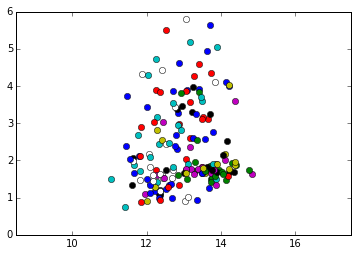

178 30 3
0 : 0.555555555556
178 30 3
1 : 0.777777777778
178 30 3
2 : 0.666666666667
178 30 3
3 : 0.833333333333
178 30 3
4 : 0.611111111111
178 30 3
5 : 0.777777777778
178 30 3
6 : 0.833333333333
178 30 3
7 : 0.666666666667
178 30 3
8 : 0.647058823529
178 30 3
9 : 0.705882352941
--------------------------------------- sigma:  50


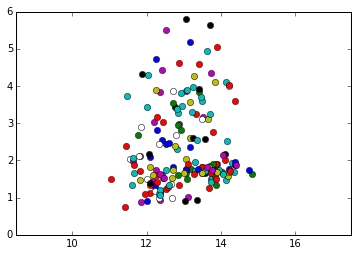

178 30 3
0 : 0.722222222222
178 30 3
1 : 0.666666666667
178 30 3
2 : 0.777777777778
178 30 3
3 : 0.722222222222
178 30 3
4 : 0.777777777778
178 30 3
5 : 0.555555555556
178 30 3
6 : 0.722222222222
178 30 3
7 : 0.5
178 30 3
8 : 0.823529411765
178 30 3
9 : 0.705882352941
--------------------------------------- sigma:  55


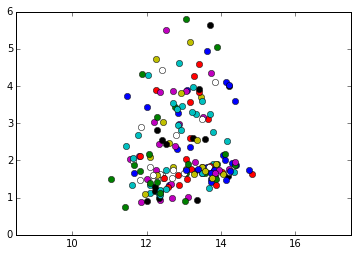

178 30 3
0 : 0.666666666667
178 30 3
1 : 0.833333333333
178 30 3
2 : 0.611111111111
178 30 3
3 : 0.722222222222
178 30 3
4 : 0.722222222222
178 30 3
5 : 0.777777777778
178 30 3
6 : 0.722222222222
178 30 3
7 : 0.833333333333
178 30 3
8 : 0.647058823529
178 30 3
9 : 0.588235294118
--------------------------------------- sigma:  60


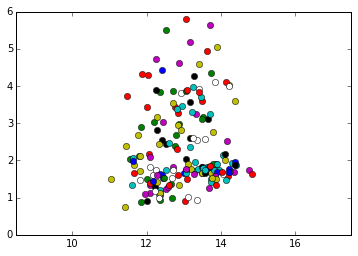

178 30 3
0 : 0.777777777778
178 30 3
1 : 0.833333333333
178 30 3
2 : 0.722222222222
178 30 3
3 : 0.611111111111
178 30 3
4 : 0.611111111111
178 30 3
5 : 0.888888888889
178 30 3
6 : 0.666666666667
178 30 3
7 : 0.722222222222
178 30 3
8 : 0.941176470588
178 30 3
9 : 0.470588235294
--------------------------------------- sigma:  65


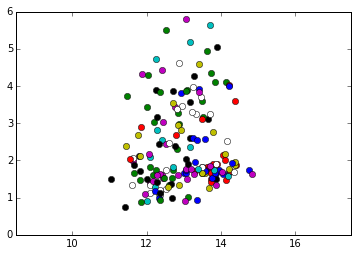

178 30 3
0 : 0.666666666667
178 30 3
1 : 0.777777777778
178 30 3
2 : 0.611111111111
178 30 3
3 : 0.833333333333
178 30 3
4 : 0.555555555556
178 30 3
5 : 0.722222222222
178 30 3
6 : 0.888888888889
178 30 3
7 : 0.555555555556
178 30 3
8 : 0.705882352941
178 30 3
9 : 0.705882352941
--------------------------------------- sigma:  70


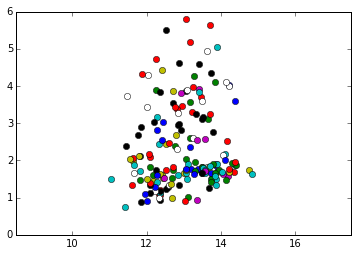

178 30 3
0 : 0.722222222222
178 30 3
1 : 0.666666666667
178 30 3
2 : 0.666666666667
178 30 3
3 : 0.944444444444
178 30 3
4 : 0.722222222222
178 30 3
5 : 0.666666666667
178 30 3
6 : 0.666666666667
178 30 3
7 : 0.666666666667
178 30 3
8 : 0.823529411765
178 30 3
9 : 0.647058823529
--------------------------------------- sigma:  75


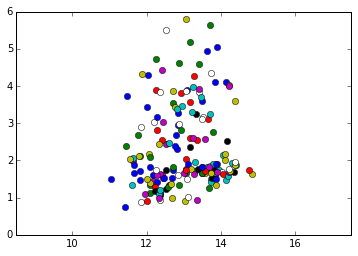

178 30 3
0 : 0.611111111111
178 30 3
1 : 0.666666666667
178 30 3
2 : 0.833333333333
178 30 3
3 : 0.833333333333
178 30 3
4 : 0.722222222222
178 30 3
5 : 0.555555555556
178 30 3
6 : 0.611111111111
178 30 3
7 : 0.722222222222
178 30 3
8 : 0.705882352941
178 30 3
9 : 0.941176470588


In [177]:
sigmas = [10,15,20,25,30,35,40,45,50,55,60,65,70,75]
wineData = pd.read_csv('data/wine.data',header=None)
wineY = wineData[0].apply(lambda x: x-1).values
wineX = wineData.drop(0,axis=1)
wineX = wineX.values
wineMeans = runSigma(wineX,wineY)

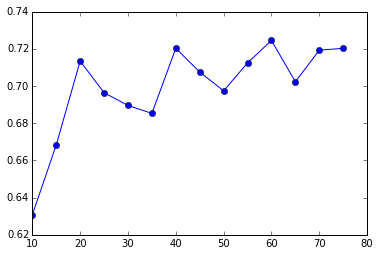

In [178]:
plt.plot(sigmas,wineMeans,'bo-')

--------------------------------------- sigma:  0.001


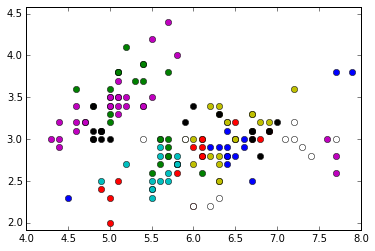

150 30 3
--------------------------------------- sigma:  0.01


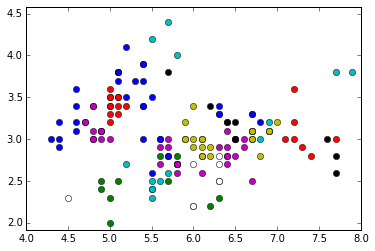

150 30 3
--------------------------------------- sigma:  0.02


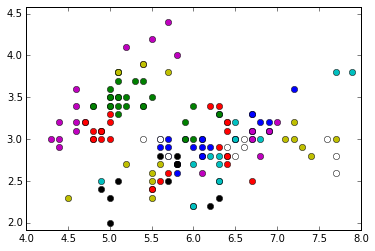

150 30 3
0 : 0.866666666667
150 30 3
1 : 0.8
150 30 3
2 : 0.866666666667
150 30 3
3 : 0.866666666667
150 30 3
4 : 0.933333333333
150 30 3
5 : 0.933333333333
150 30 3
6 : 0.866666666667
150 30 3
7 : 0.933333333333
150 30 3
8 : 0.8
150 30 3
9 : 0.8
--------------------------------------- sigma:  0.05


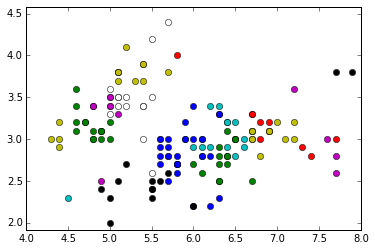

150 30 3
0 : 0.933333333333
150 30 3
1 : 0.8
150 30 3
2 : 0.666666666667
150 30 3
3 : 0.733333333333
150 30 3
4 : 0.8
150 30 3
5 : 0.933333333333
150 30 3
6 : 0.866666666667
150 30 3
7 : 0.866666666667
150 30 3
8 : 0.666666666667
150 30 3
9 : 0.8
--------------------------------------- sigma:  0.1


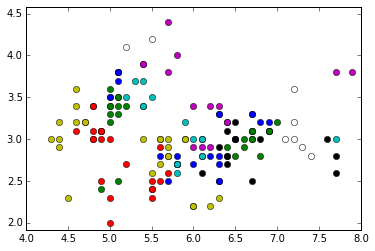

150 30 3
0 : 0.866666666667
150 30 3
1 : 1.0
150 30 3
2 : 1.0
150 30 3
3 : 0.8
150 30 3
4 : 0.866666666667
150 30 3
5 : 0.8
150 30 3
6 : 1.0
150 30 3
7 : 0.933333333333
150 30 3
8 : 0.933333333333
150 30 3
9 : 0.866666666667
--------------------------------------- sigma:  0.2


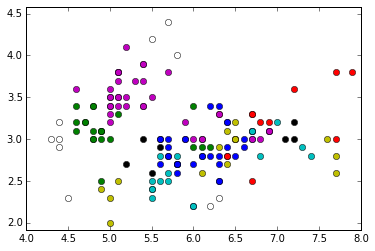

150 30 3
0 : 0.933333333333
150 30 3
1 : 0.866666666667
150 30 3
2 : 0.933333333333
150 30 3
3 : 0.866666666667
150 30 3
4 : 0.933333333333
150 30 3
5 : 0.933333333333
150 30 3
6 : 1.0
150 30 3
7 : 1.0
150 30 3
8 : 0.733333333333
150 30 3
9 : 0.933333333333
--------------------------------------- sigma:  0.3


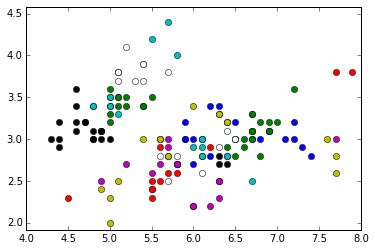

150 30 3
0 : 0.8
150 30 3
1 : 0.866666666667
150 30 3
2 : 1.0
150 30 3
3 : 1.0
150 30 3
4 : 0.933333333333
150 30 3
5 : 1.0
150 30 3
6 : 0.733333333333
150 30 3
7 : 0.933333333333
150 30 3
8 : 1.0
150 30 3
9 : 1.0
--------------------------------------- sigma:  0.4


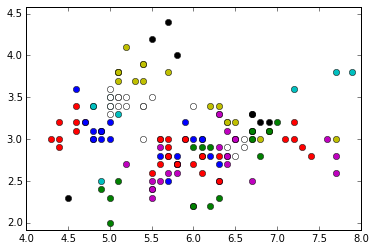

150 30 3
0 : 0.933333333333
150 30 3
1 : 0.933333333333
150 30 3
2 : 1.0
150 30 3
3 : 0.866666666667
150 30 3
4 : 0.866666666667
150 30 3
5 : 1.0
150 30 3
6 : 1.0
150 30 3
7 : 1.0
150 30 3
8 : 1.0
150 30 3
9 : 1.0
--------------------------------------- sigma:  0.5


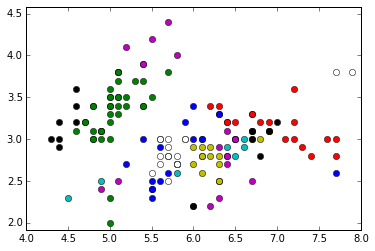

150 30 3
0 : 1.0
150 30 3
1 : 1.0
150 30 3
2 : 1.0
150 30 3
3 : 0.866666666667
150 30 3
4 : 0.866666666667
150 30 3
5 : 0.866666666667
150 30 3
6 : 1.0
150 30 3
7 : 0.866666666667
150 30 3
8 : 1.0
150 30 3
9 : 0.866666666667
--------------------------------------- sigma:  0.6


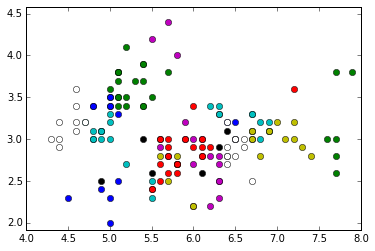

150 30 3
0 : 0.933333333333
150 30 3
1 : 1.0
150 30 3
2 : 1.0
150 30 3
3 : 1.0
150 30 3
4 : 0.933333333333
150 30 3
5 : 0.933333333333
150 30 3
6 : 0.933333333333
150 30 3
7 : 1.0
150 30 3
8 : 0.933333333333
150 30 3
9 : 0.933333333333
--------------------------------------- sigma:  0.7


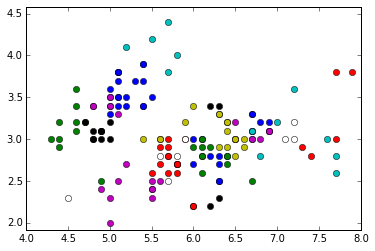

150 30 3
0 : 0.866666666667
150 30 3
1 : 1.0
150 30 3
2 : 0.933333333333
150 30 3
3 : 0.866666666667
150 30 3
4 : 0.933333333333
150 30 3
5 : 0.933333333333
150 30 3
6 : 1.0
150 30 3
7 : 1.0
150 30 3
8 : 1.0
150 30 3
9 : 1.0
--------------------------------------- sigma:  0.8


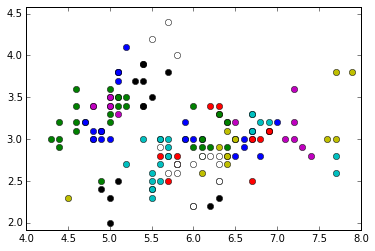

150 30 3
0 : 0.933333333333
150 30 3
1 : 1.0
150 30 3
2 : 0.866666666667
150 30 3
3 : 1.0
150 30 3
4 : 0.733333333333
150 30 3
5 : 1.0
150 30 3
6 : 0.933333333333
150 30 3
7 : 1.0
150 30 3
8 : 1.0
150 30 3
9 : 0.866666666667
--------------------------------------- sigma:  0.9


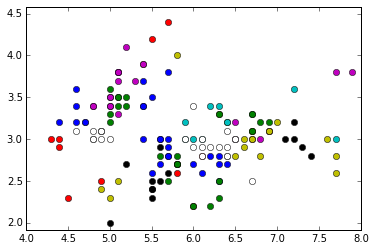

150 30 3
0 : 0.8
150 30 3
1 : 0.8
150 30 3
2 : 0.933333333333
150 30 3
3 : 0.866666666667
150 30 3
4 : 0.933333333333
150 30 3
5 : 1.0
150 30 3
6 : 1.0
150 30 3
7 : 0.733333333333
150 30 3
8 : 0.8
150 30 3
9 : 0.8
--------------------------------------- sigma:  1


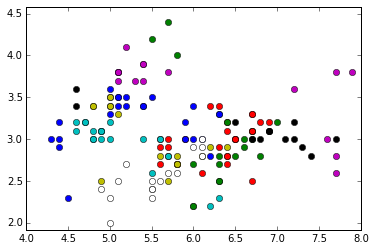

150 30 3
0 : 0.866666666667
150 30 3
1 : 0.866666666667
150 30 3
2 : 0.866666666667
150 30 3
3 : 0.6
150 30 3
4 : 0.733333333333
150 30 3
5 : 0.866666666667
150 30 3
6 : 0.733333333333
150 30 3
7 : 0.666666666667
150 30 3
8 : 0.666666666667
150 30 3
9 : 1.0


In [179]:
sigmas = [.001,.01,.02,.05,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
def irisLableSet(name):
    names = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
    for i in xrange(3):
        if names[i] == name:
            return i
irisData = pd.read_csv('data/iris.data',header=None)
irisY = irisData[4].apply(irisLableSet).values
irisX = irisData.drop(4,axis=1)
irisX = irisX.values
irisMeans = runSigma(irisX,irisY)

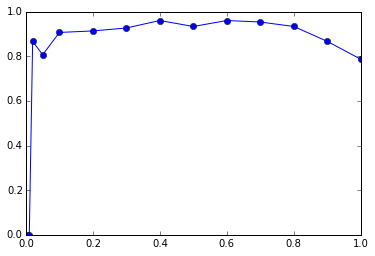

In [180]:
plt.plot(sigmas,irisMeans,'bo-')

--------------------------------------- sigma:  0.5


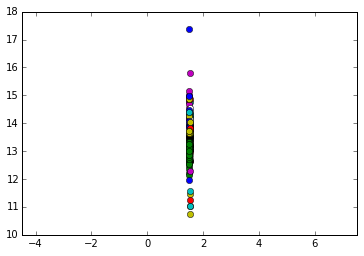

214 30 6
0 : 0.590909090909
214 30 6
1 : 0.590909090909
214 30 6
2 : 0.454545454545
214 30 6
3 : 0.318181818182
214 30 6
4 : 0.238095238095
214 30 6
5 : 0.47619047619
214 30 6
6 : 0.47619047619
214 30 6
7 : 0.619047619048
214 30 6
8 : 0.666666666667
214 30 6
9 : 0.428571428571
--------------------------------------- sigma:  0.8


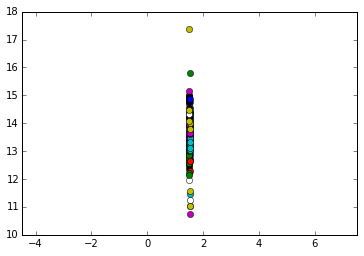

214 30 6
0 : 0.590909090909
214 30 6
1 : 0.545454545455
214 30 6
2 : 0.454545454545
214 30 6
3 : 0.227272727273
214 30 6
4 : 0.47619047619
214 30 6
5 : 0.47619047619
214 30 6
6 : 0.666666666667
214 30 6
7 : 0.428571428571
214 30 6
8 : 0.52380952381
214 30 6
9 : 0.47619047619
--------------------------------------- sigma:  1


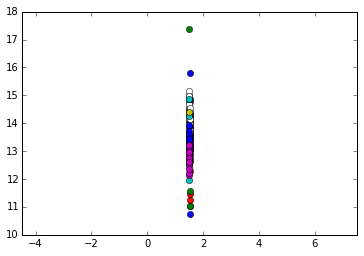

214 30 6
0 : 0.409090909091
214 30 6
1 : 0.409090909091
214 30 6
2 : 0.636363636364
214 30 6
3 : 0.409090909091
214 30 6
4 : 0.666666666667
214 30 6
5 : 0.47619047619
214 30 6
6 : 0.52380952381
214 30 6
7 : 0.380952380952
214 30 6
8 : 0.619047619048
214 30 6
9 : 0.333333333333
--------------------------------------- sigma:  2


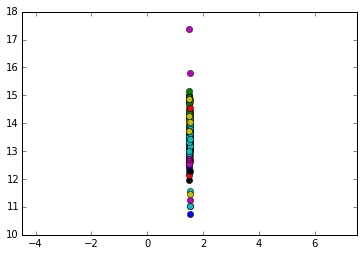

214 30 6
0 : 0.318181818182
214 30 6
1 : 0.409090909091
214 30 6
2 : 0.5
214 30 6
3 : 0.681818181818
214 30 6
4 : 0.428571428571
214 30 6
5 : 0.428571428571
214 30 6
6 : 0.47619047619
214 30 6
7 : 0.285714285714
214 30 6
8 : 0.238095238095
214 30 6
9 : 0.428571428571
--------------------------------------- sigma:  3


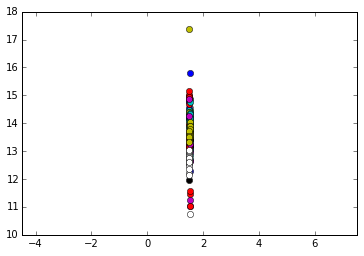

214 30 6
0 : 0.636363636364
214 30 6
1 : 0.545454545455
214 30 6
2 : 0.545454545455
214 30 6
3 : 0.5
214 30 6
4 : 0.666666666667
214 30 6
5 : 0.47619047619
214 30 6
6 : 0.666666666667
214 30 6
7 : 0.47619047619
214 30 6
8 : 0.238095238095
214 30 6
9 : 0.47619047619
--------------------------------------- sigma:  4


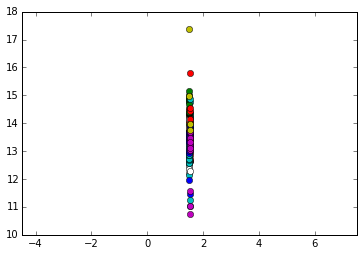

214 30 6
0 : 0.409090909091
214 30 6
1 : 0.409090909091
214 30 6
2 : 0.272727272727
214 30 6
3 : 0.454545454545
214 30 6
4 : 0.428571428571
214 30 6
5 : 0.238095238095
214 30 6
6 : 0.238095238095
214 30 6
7 : 0.52380952381
214 30 6
8 : 0.285714285714
214 30 6
9 : 0.380952380952
--------------------------------------- sigma:  5


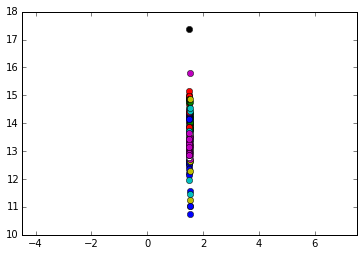

214 30 6
0 : 0.227272727273
214 30 6
1 : 0.363636363636
214 30 6
2 : 0.318181818182
214 30 6
3 : 0.409090909091
214 30 6
4 : 0.285714285714
214 30 6
5 : 0.238095238095
214 30 6
6 : 0.380952380952
214 30 6
7 : 0.333333333333
214 30 6
8 : 0.333333333333
214 30 6
9 : 0.380952380952
--------------------------------------- sigma:  8


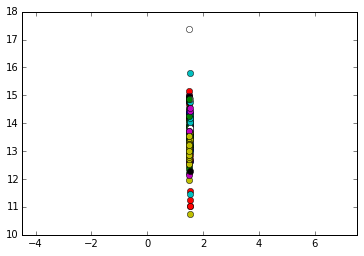

214 30 6
0 : 0.318181818182
214 30 6
1 : 0.454545454545
214 30 6
2 : 0.227272727273
214 30 6
3 : 0.409090909091
214 30 6
4 : 0.190476190476
214 30 6
5 : 0.333333333333
214 30 6
6 : 0.333333333333
214 30 6
7 : 0.47619047619
214 30 6
8 : 0.285714285714
214 30 6
9 : 0.52380952381
--------------------------------------- sigma:  10


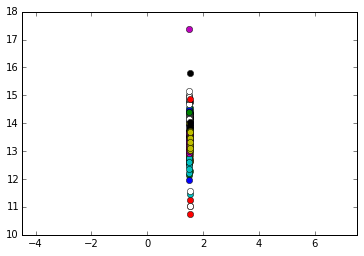

214 30 6
0 : 0.363636363636
214 30 6
1 : 0.409090909091
214 30 6
2 : 0.272727272727
214 30 6
3 : 0.5
214 30 6
4 : 0.0952380952381
214 30 6
5 : 0.333333333333
214 30 6
6 : 0.571428571429
214 30 6
7 : 0.47619047619
214 30 6
8 : 0.285714285714
214 30 6
9 : 0.238095238095
--------------------------------------- sigma:  15


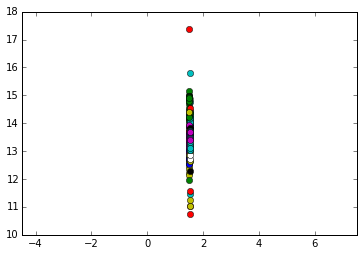

214 30 6
0 : 0.409090909091
214 30 6
1 : 0.227272727273
214 30 6
2 : 0.454545454545
214 30 6
3 : 0.318181818182
214 30 6
4 : 0.333333333333
214 30 6
5 : 0.285714285714
214 30 6
6 : 0.333333333333
214 30 6
7 : 0.380952380952
214 30 6
8 : 0.380952380952
214 30 6
9 : 0.428571428571
--------------------------------------- sigma:  20


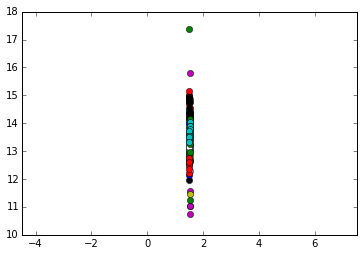

214 30 6
0 : 0.272727272727
214 30 6
1 : 0.363636363636
214 30 6
2 : 0.409090909091
214 30 6
3 : 0.227272727273
214 30 6
4 : 0.333333333333
214 30 6
5 : 0.238095238095
214 30 6
6 : 0.428571428571
214 30 6
7 : 0.571428571429
214 30 6
8 : 0.428571428571
214 30 6
9 : 0.285714285714
--------------------------------------- sigma:  25


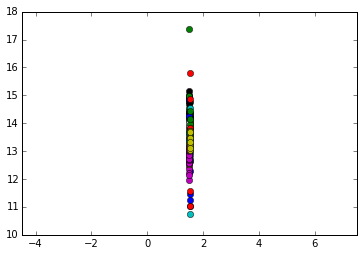

214 30 6
0 : 0.227272727273
214 30 6
1 : 0.272727272727
214 30 6
2 : 0.454545454545
214 30 6
3 : 0.363636363636
214 30 6
4 : 0.380952380952
214 30 6
5 : 0.190476190476
214 30 6
6 : 0.142857142857
214 30 6
7 : 0.47619047619
214 30 6
8 : 0.238095238095
214 30 6
9 : 0.333333333333
--------------------------------------- sigma:  30


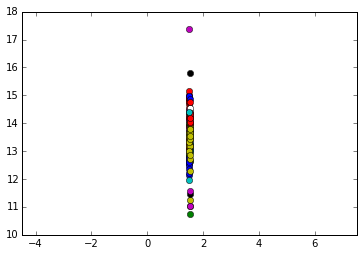

214 30 6
0 : 0.272727272727
214 30 6
1 : 0.318181818182
214 30 6
2 : 0.454545454545
214 30 6
3 : 0.318181818182
214 30 6
4 : 0.428571428571
214 30 6
5 : 0.333333333333
214 30 6
6 : 0.333333333333
214 30 6
7 : 0.47619047619
214 30 6
8 : 0.238095238095
214 30 6
9 : 0.380952380952
--------------------------------------- sigma:  35


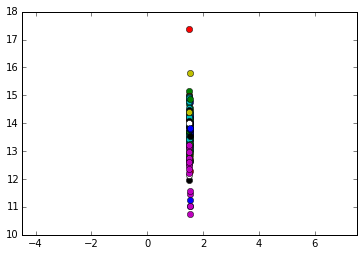

214 30 6
0 : 0.136363636364
214 30 6
1 : 0.272727272727
214 30 6
2 : 0.363636363636
214 30 6
3 : 0.454545454545
214 30 6
4 : 0.333333333333
214 30 6
5 : 0.333333333333
214 30 6
6 : 0.380952380952
214 30 6
7 : 0.333333333333
214 30 6
8 : 0.285714285714
214 30 6
9 : 0.285714285714


In [185]:
sigmas = [.5,.8,1,2,3,4,5,8,10,15,20,25,30,35]
glassData = pd.read_csv('data/glass.data',header=None)
glassY = glassData[10].apply(lambda x: x-1 if x<4 else x-2).values
glassX = glassData.drop([0,10],axis=1)
glassX = glassX.values
glassMeans = runSigma(glassX,glassY)

14


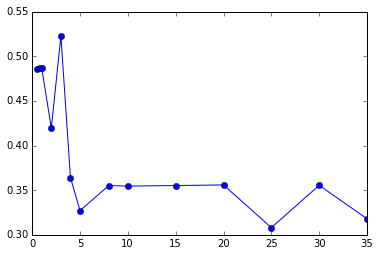

In [186]:
print len(sigmas)
plt.plot(sigmas,glassMeans,'bo-')

--------------------------------------- sigma:  0.01


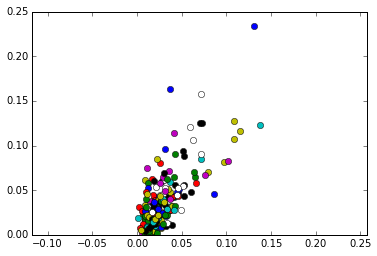

[  0   1   2   3   4   5   7   8   9  10  11  12  13  14  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  41  42  44  45  47  48  49  50  51  52  54  56  57  58  59  60
  61  62  63  64  65  66  68  69  70  71  72  73  74  75  76  77  78  80
  81  82  83  84  85  87  88  89  90  91  92  93  94  95  96  97  99 101
 102 104 105 106 107 108 109 110 111 112 115 116 117 118 119 120 121 122
 123 124 125 126 127 128 129 130 131 132 133 134 136 137 138 139 140 142
 144 145 146 147 149 150 151 152 153 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 193 194 195 196 197 198 199 200
 201 202 203 204 205 206 207]
[  6  15  40  43  46  53  55  67  79  86  98 100 103 113 114 135 141 143
 148 154 192]
y====
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

ValueError: Input must be 1- or 2-d.

In [214]:
sigmas = [.01,.02,.03,0.4,.05,.1,.2,.3,.4,.5,.6,.7,.8,.9]
sonarData = pd.read_csv('data/sonar.data',header=None)
sonarY = (sonarData[60].apply(lambda x: 0 if x=='M' else 1)).values
sonarX = sonarData.drop(60,axis=1)
sonarX = sonarX.values
sonarMeans = runSigma(sonarX,sonarY)

In [213]:
sonarData.tail()

0       1       2       3       4       5       6       7       8   \
203  0.0187  0.0346  0.0168  0.0177  0.0393  0.1630  0.2028  0.1694  0.2328   
204  0.0323  0.0101  0.0298  0.0564  0.0760  0.0958  0.0990  0.1018  0.1030   
205  0.0522  0.0437  0.0180  0.0292  0.0351  0.1171  0.1257  0.1178  0.1258   
206  0.0303  0.0353  0.0490  0.0608  0.0167  0.1354  0.1465  0.1123  0.1945   
207  0.0260  0.0363  0.0136  0.0272  0.0214  0.0338  0.0655  0.1400  0.1843   

         9  ...      51      52      53      54      55      56      57  \
203  0.2684 ...  0.0116  0.0098  0.0199  0.0033  0.0101  0.0065  0.0115   
204  0.2154 ...  0.0061  0.0093  0.0135  0.0063  0.0063  0.0034  0.0032   
205  0.2529 ...  0.0160  0.0029  0.0051  0.0062  0.0089  0.0140  0.0138   
206  0.2354 ...  0.0086  0.0046  0.0126  0.0036  0.0035  0.0034  0.0079   
207  0.2354 ...  0.0146  0.0129  0.0047  0.0039  0.0061  0.0040  0.0036   

         58      59  60  
203  0.0193  0.0157   M  
204  0.0062  0.0067   M  
205  0.0077  0.0031   M  
206  0.0036  0.0048   M  
207  0.0061  0.0115   M  

[5 rows x 61 columns]

In [ ]:
plt.plot(sigmas,sonarMeans,'bo-')

In [192]:
print 'iris:',irisMeans.max()
print 'sonar:',sonarMeans.max()
print 'glass:',glassMeans.max()
print 'wine:',wineMeans.max()

iris: 0.96
sonar: 0.0
glass: 0.522727272727
wine: 0.724509803922


In [117]:
from sklearn.decomposition import FastICA
def ICA1NN(X,y):
    numS = X.shape[0]
    kf = KFold(numS,n_folds=10,shuffle=True)
    i = 0
    acc = []
    for train_index,test_index in kf:
        ica = FastICA()
        X_ica = ica.fit(X[train_index])
        X_test = ica.transform(X[test_index])
        NN = neighbors.KNeighborsClassifier()
        NN.fit(X_ica,y)
        XPred = NN.predict(X_test)
        acc.append(np.sum(XPred==y[test_index])*1.0/y[test_index].shape[0])
        print acc[i]
        i += 1
    return np.mean(acc)

In [118]:
wineData = pd.read_csv('data/wine.data',header=None)
wineY = wineData[0].apply(lambda x: x-1).values
wineX = wineData.drop(0,axis=1)
wineX = wineX.values
ICA1NN(wineX,wineY)

c:\Anaconda\lib\site-packages\sklearn\decomposition\fastica_.py:110: UserWarning: FastICA did not converge. You might want to increase the number of iterations.
  ' to increase the number of iterations.')


TypeError: Expected sequence or array-like, got FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=200,
    n_components=None, random_state=None, tol=0.0001, w_init=None,
    whiten=True)